In [1]:
import os, glob, re
import shutil
import random
import json
import pyarrow.parquet as pq
import numpy as np
import h5py
import math
import time
from tqdm import tqdm
from multiprocessing import Pool

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])
minimum_nonzero_pixels = 3

# def estimate_population_parameters(all_sample_sizes, all_sample_means, all_sample_stds):
#     population_means = []
#     population_stds = []
#     for j in range(len(all_sample_means)):
#         sample_means = all_sample_means[j]
#         sample_stds = all_sample_stds[j]
#         sample_sizes = all_sample_sizes[j]
#         sample_means = sample_means[sample_sizes != 0]
#         sample_stds = sample_stds[sample_sizes != 0]
#         sample_sizes = sample_sizes[sample_sizes != 0]
#         weighted_sum_of_variances = sum((n - 1) * s**2 for n, s in zip(sample_sizes, sample_stds))
#         total_degrees_of_freedom = sum(n - 1 for n in sample_sizes)
#         combined_variance = weighted_sum_of_variances / total_degrees_of_freedom
#         population_std = np.sqrt(combined_variance)
#         weighted_sum_of_means = sum(n * mean for n, mean in zip(sample_sizes, sample_means))
#         total_observations = sum(sample_sizes)
#         population_mean = weighted_sum_of_means / total_observations
#         population_stds.append(population_std)
#         population_means.append(population_mean)

#     return population_means, population_stds

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [int(c) if c.isdigit() else c for c in re.split('([0-9]+)',s)]

### Mean and std with outliers

In [2]:
def mean_std_original(file="/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_train_hd5/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_0000_train.h5",outdir = "mean_std_record_original_data_set", batch_size=7000, minimum_nonzero_pixels=3):
    print(f"processing file ---> {file}\n")
    tag = file.split('_')[-2]
    data = h5py.File(file, 'r')
    # num_images = data["all_jet"].shape[0]
    # batch_size = batch_size
    num_images = 100000
    batch_size = 10
    print(f"data size: {num_images}\n")
    size_ = []
    mean_ = []
    std_ = []
    
    for start_idx in tqdm(range(0, num_images, batch_size)):
        end_idx = min(start_idx + batch_size, num_images)
        images_batch = data["all_jet"][start_idx:end_idx, :, :, :]
        images_batch[np.abs(images_batch) < 1.e-5] = 0
        non_zero_mask = images_batch != 0
        images_non_zero = np.where(non_zero_mask, images_batch, np.nan)
        size_channel = np.count_nonzero(non_zero_mask, axis=(2, 3))
        mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
        std_channel = np.nanstd(images_non_zero, axis=(2, 3), ddof=1)
        non_empty_event = np.all(size_channel > minimum_nonzero_pixels, axis=1)
        mean_channel = mean_channel[non_empty_event]
        std_channel = std_channel[non_empty_event]
        size_channel = size_channel[non_empty_event]
        size_.append(size_channel)
        mean_.append(mean_channel)
        std_.append(std_channel)

    data.close()  
    size_ = np.concatenate(size_, axis=0).T
    mean_ = np.concatenate(mean_, axis=0).T
    std_ = np.concatenate(std_, axis=0).T
    # print("size: ", size_.shape)
    # print("mean: ", mean_.shape)
    # print("std : ", std_.shape)
#     orig_mean, orig_std = estimate_population_parameters(size_, mean_, std_)


#     print(f'Means with outliers: {orig_mean}\n' )
#     print(f'Stds with outliers : { orig_std}\n')

    stat = {
            "original_mean":mean_.tolist(),
            "original_std":std_.tolist(),
            "number_of_jets":size_.tolist()
            }

    if not os.path.exists(outdir):
        os.makedirs(outdir)

    with open(outdir +'/'+ f'original_mean_std_record_dataset_{tag}.json', 'w') as fp:
        json.dump(stat, fp)
    
    # return mean_, std_

### Calculate mean and std of original samples

In [3]:
# ### Run only once to calculate original mean and std
# def process_files(file):
#     file_path = file[0]
#     mean_std_original(file=file_path,outdir = "/pscratch/sd/b/bbbam/mean_std_for_plot", batch_size=14000, minimum_nonzero_pixels=0)
    
# file_list = glob.glob("/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_train_hd5/*")   
# args = list(zip(file_list)) 
# with Pool(10) as p:
#     p.map(process_files,args)

In [4]:
all_files = glob.glob("/pscratch/sd/b/bbbam/mean_std_for_plot_test/*")
all_files

['/pscratch/sd/b/bbbam/mean_std_for_plot_test/original_mean_std_record_dataset_0001.json',
 '/pscratch/sd/b/bbbam/mean_std_for_plot_test/original_mean_std_record_dataset_0002.json',
 '/pscratch/sd/b/bbbam/mean_std_for_plot_test/original_mean_std_record_dataset_0004.json',
 '/pscratch/sd/b/bbbam/mean_std_for_plot_test/original_mean_std_record_dataset_0005.json',
 '/pscratch/sd/b/bbbam/mean_std_for_plot_test/original_mean_std_record_dataset_0000.json',
 '/pscratch/sd/b/bbbam/mean_std_for_plot_test/original_mean_std_record_dataset_0006.json',
 '/pscratch/sd/b/bbbam/mean_std_for_plot_test/original_mean_std_record_dataset_0008.json',
 '/pscratch/sd/b/bbbam/mean_std_for_plot_test/original_mean_std_record_dataset_0003.json',
 '/pscratch/sd/b/bbbam/mean_std_for_plot_test/original_mean_std_record_dataset_0009.json',
 '/pscratch/sd/b/bbbam/mean_std_for_plot_test/original_mean_std_record_dataset_0007.json']

In [36]:
orig_mean  =  np.array([1.96564565e+00, 2.08263890e+02, 5.58348869e+00, 4.31304512e-01,
 2.56358780e-02, 1.03114537e+00, 1.02714137e+00, 1.03126102e+00,
 1.03864744e+00, 1.63181412e+00, 1.68669425e+00, 1.68518954e+00,
 1.68931466e+00]) 

orig_std  =  np.array([1.64547331e+02, 2.40326927e+02, 3.08302240e+01, 2.06503512e+00,
 8.01002674e-02, 1.84443168e-01, 1.70208005e-01, 1.83686938e-01,
 2.07823703e-01, 1.00027121e+00, 1.09456862e+00, 1.08181558e+00,
 1.12996825e+00]) 

totoal_samples  =  np.array([419691, 419687, 438180, 419703, 419701, 429739, 431463, 428918, 419665, 428952]) 

after_outlier_mean  =  np.array([1.94187487e+00, 2.08261770e+02, 5.58177329e+00, 4.31304269e-01,
 2.56358990e-02, 1.03114542e+00, 1.02714137e+00, 1.03126105e+00,
 1.03864745e+00, 1.63181452e+00, 1.68669463e+00, 1.68518982e+00,
 1.68931468e+00]) 

after_outlier_std  =  np.array([2.71139741e+01, 2.40285633e+02, 3.06056467e+01, 2.06503835e+00,
 8.01002918e-02, 1.84443340e-01, 1.70208019e-01, 1.83687021e-01,
 2.07823705e-01, 1.00027157e+00, 1.09456875e+00, 1.08181565e+00,
 1.12996794e+00]) 

after_outlier_selected_jets =  np.array([383216, 400368, 383230, 383125, 391450, 383631, 391998, 393935, 392235, 383309]) 
channel = ['Tracks_pt', 'dZSig', 'd0Sig', 'ECAL_energy', 'HBHE_energy', 'Pix_1', 'Pix_2', 'Pix_3', 'Pix_4', 'Tib_1', 'Tib_2','Tob_1', 'Tob_1']


In [37]:
mean_ = []
std_ = []
size_ = []
file_path = glob.glob("/pscratch/sd/b/bbbam/mean_std_for_plot_test/*")
# for file in file_path:
#     with open(file, 'r') as file:
#         data = json.load(file)
#     mean_.append(data['original_mean'])
#     std_.append(data['original_std'])
#     size_.append(data['number_of_jets'])
# mean = np.array(mean_)
# std = np.array(std_)
# size = np.array(size_)

with open(file_path[0], 'r') as file:
    data = json.load(file)
    print(data.keys())


dict_keys(['original_mean', 'original_std', 'number_of_jets'])


In [50]:
orig_std[0]#+10*orig_std[0]

164.547331

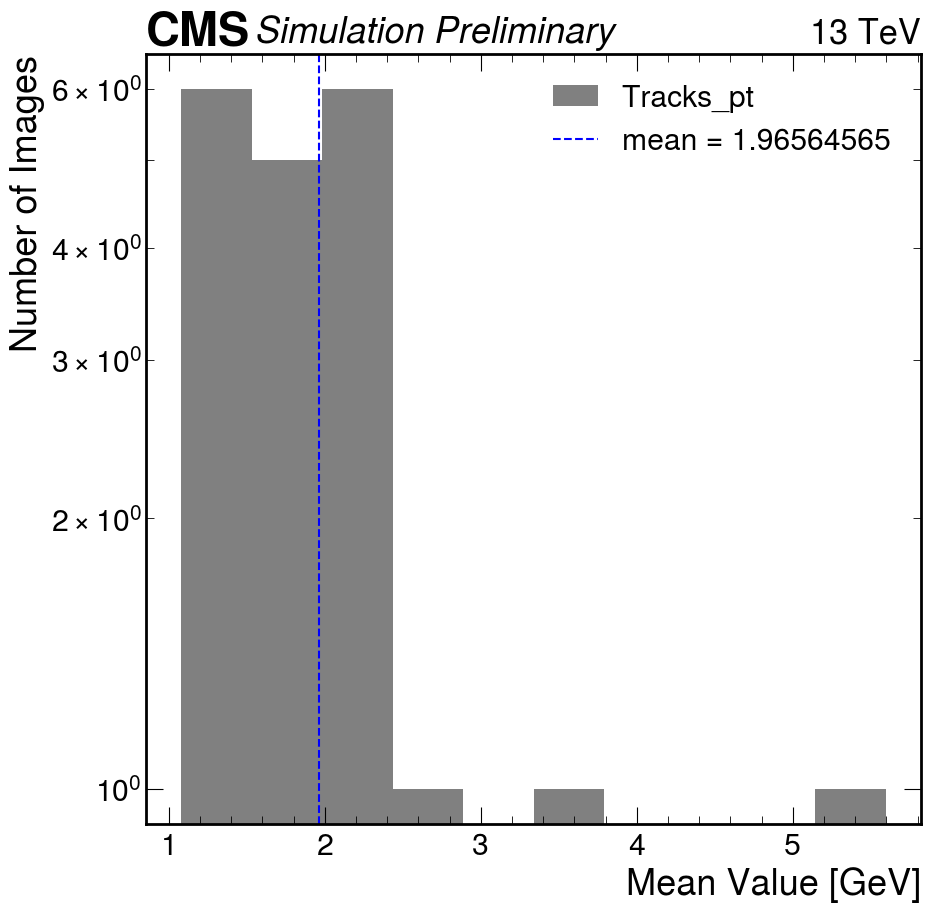

In [47]:
mean = np.array(data['original_mean'])

# Plotting
fig, ax = plt.subplots()
plt.hist(mean[0],color = 'grey', label=f'{channel[0]} ')
plt.axvline(x=orig_mean[0], linestyle='--', color='b', label=f'mean = {orig_mean[0]}')
# plt.axvline(x=orig_mean[0]+10*orig_std[0], linestyle='--', color='r', label= f'oulier boundery {orig_mean[0]+10*orig_std[0]}')
plt.xlabel('Mean Value [GeV]')
plt.ylabel('Number of Images')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
# plt.grid(True)
plt.legend()
plt.yscale('log')
plt.show()

### Calculate combined mean and std for original data

In [2]:
def combined_mean_std(size, mean, std):
    mean_ = np.dot(size, mean)/np.sum(size)
    std_ = np.sqrt((np.dot((np.array(size)-1), np.square(std)) + np.dot(size,np.square(mean-mean_)))/(np.sum(size)-1))
    return mean_, std_

mean_ = []
std_ = []
size_ = []
file_path = glob.glob("mean_std_record_original_dataset/*")
for file in file_path:
    with open(file, 'r') as file:
        data = json.load(file)
    mean_.append(data['original_mean'])
    std_.append(data['original_std'])
    size_.append(data['number_of_jets'])
mean = np.array(mean_)
std = np.array(std_)
size = np.array(size_)


orig_mean, orig_std = combined_mean_std(size, mean, std)
print("original mean  :" , orig_mean,"\n")
print("original std  :" , orig_std,"\n")

original mean  : [1.96564565e+00 2.08263890e+02 5.58348869e+00 4.31304512e-01
 2.56358780e-02 1.03114537e+00 1.02714137e+00 1.03126102e+00
 1.03864744e+00 1.63181412e+00 1.68669425e+00 1.68518954e+00
 1.68931466e+00] 

original std  : [1.64547331e+02 2.40326927e+02 3.08302240e+01 2.06503512e+00
 8.01002674e-02 1.84443168e-01 1.70208005e-01 1.83686938e-01
 2.07823703e-01 1.00027121e+00 1.09456862e+00 1.08181558e+00
 1.12996825e+00] 



### count events after cut

In [3]:
orig_mean  =  np.array([1.96564565e+00, 2.08263890e+02, 5.58348869e+00, 4.31304512e-01,
 2.56358780e-02, 1.03114537e+00, 1.02714137e+00, 1.03126102e+00,
 1.03864744e+00, 1.63181412e+00, 1.68669425e+00, 1.68518954e+00,
 1.68931466e+00]) 

orig_std  =  np.array([1.64547331e+02, 2.40326927e+02, 3.08302240e+01, 2.06503512e+00,
 8.01002674e-02, 1.84443168e-01, 1.70208005e-01, 1.83686938e-01,
 2.07823703e-01, 1.00027121e+00, 1.09456862e+00, 1.08181558e+00,
 1.12996825e+00]) 

totoal_samples  =  np.array([419691, 419687, 438180, 419703, 419701, 429739, 431463, 428918, 419665, 428952]) 

after_outlier_mean  =  np.array([1.94187487e+00, 2.08261770e+02, 5.58177329e+00, 4.31304269e-01,
 2.56358990e-02, 1.03114542e+00, 1.02714137e+00, 1.03126105e+00,
 1.03864745e+00, 1.63181452e+00, 1.68669463e+00, 1.68518982e+00,
 1.68931468e+00]) 

after_outlier_std  =  np.array([2.71139741e+01, 2.40285633e+02, 3.06056467e+01, 2.06503835e+00,
 8.01002918e-02, 1.84443340e-01, 1.70208019e-01, 1.83687021e-01,
 2.07823705e-01, 1.00027157e+00, 1.09456875e+00, 1.08181565e+00,
 1.12996794e+00]) 

after_outlier_selected_jets =  np.array([383216, 400368, 383230, 383125, 391450, 383631, 391998, 393935, 392235, 383309]) 
channel = ['Tracks_pt', 'dZSig', 'd0Sig', 'ECAL_energy', 'HBHE_energy', 'Pix_1', 'Pix_2', 'Pix_3', 'Pix_4', 'Tib_1', 'Tib_2','Tob_1', 'Tob_1']

file="/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_train_hd5/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_0000_train.h5"

minimum_nonzero_pixels=0
print(f"processing file ---> {file}\n")
tag = file.split('_')[-2]
data = h5py.File(file, 'r')


size_ = []
mean_ = []
std_ = []

num_images = data["all_jet"].shape[0]
batch_size=20000 
num_images = 100000
# batch_size =100
num_pass_0 = 0
num_pass_1 = 0
num_pass_2 = 0

print(f"data size: {num_images}\n")
for start_idx in tqdm(range(0, num_images, batch_size)):
    end_idx = min(start_idx + batch_size, num_images)
    images_batch = data["all_jet"][start_idx:end_idx, :, :, :]
    images_batch[np.abs(images_batch) < 1.e-5] = 0
    non_zero_mask = images_batch != 0
    images_non_zero = np.where(non_zero_mask, images_batch, np.nan)
    size_channel = np.count_nonzero(non_zero_mask, axis=(2, 3))
    mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
    std_channel = np.nanstd(images_non_zero, axis=(2, 3), ddof=1)
   
    # print("mean_channel 0  :", mean_channel.shape)
    num_pass_0 = num_pass_0 + mean_channel.shape[0]
   
    
    non_empty_event = np.all(size_channel > minimum_nonzero_pixels, axis=1)
    mean_channel = mean_channel[non_empty_event]
    std_channel = std_channel[non_empty_event]
    size_channel = size_channel[non_empty_event]
    
    # print("mean_channel 1  :", mean_channel.shape)
    num_pass_1 = num_pass_1 + mean_channel.shape[0]
    
    
    non_outlier_event = np.all(np.logical_and(size_channel > 1, mean_channel < (orig_mean + 10 * orig_std)), axis=1)
    size_channel = size_channel[non_outlier_event]
    mean_channel = mean_channel[non_outlier_event]
    std_channel = std_channel[non_outlier_event]
    
    # print("mean_channel  2 :", mean_channel.shape)
    num_pass_2 = num_pass_2 + mean_channel.shape[0]
   
    
    size_.append(size_channel)
    mean_.append(mean_channel)
    std_.append(std_channel)

data.close()  
size_ = np.concatenate(size_, axis=0).T
mean_ = np.concatenate(mean_, axis=0).T
std_ = np.concatenate(std_, axis=0).T
print(" num_pass_0 ",  num_pass_0)
print(" num_pass_1 ",  num_pass_1, (num_pass_0-num_pass_1)/num_pass_0 *100,"%")
print(" num_pass_2 ",  num_pass_2, (num_pass_1-num_pass_2)/num_pass_1 *100,"%")




processing file ---> /pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_train_hd5/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_0000_train.h5

data size: 100000



  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_1764881/3360899457.py:54: RuntimeWarning: Mean of empty slice
  mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
100%|██████████| 5/5 [10:57<00:00, 131.52s/it]

 num_pass_0  100000
 num_pass_1  99871 0.129 %
 num_pass_2  99679 0.19224799991989666 %


### plot non-oulier mean and original mean

In [2]:
def combined_mean_std(size, mean, std):
    mean_ = np.dot(size, mean)/np.sum(size)
    std_ = np.sqrt((np.dot((np.array(size)-1), np.square(std)) + np.dot(size,np.square(mean-mean_)))/(np.sum(size)-1))
    return mean_, std_

mean_ = []
std_ = []
size_ = []
file_path = glob.glob("mean_std_record_original_dataset/*")
for file in file_path:
    with open(file, 'r') as file:
        data = json.load(file)
    mean_.append(data['original_mean'])
    std_.append(data['original_std'])
    size_.append(data['number_of_jets'])
mean = np.array(mean_)
std = np.array(std_)
size = np.array(size_)


orig_mean, orig_std = combined_mean_std(size, mean, std)
print("original mean  :" , orig_mean,"\n")
print("original std  :" , orig_std,"\n")



def h5_h5_normalizes(file_):
    
    num_pass_0 = 0
    num_pass_1 = 0
    num_pass_2 = 0
    
    file = file_
    data = h5py.File(f'{file}', 'r')
    num_images = data["all_jet"].shape[0]
    num_images = 100000
    batch_size = 10000
    print(f"processing file ---> {file}\n")
    tag = file.split('_')[-2]


    outdir = 'mean_std_record_of_original_and_non_outlier_data'
    
    size_orig = []
    mean_orig = []
    std_orig = []
    
    size_ = []
    mean_ = []
    std_ = []
    
    for start_idx in tqdm(range(0, num_images, batch_size)):
        end_idx = min(start_idx + batch_size, num_images)
        images_batch = data["all_jet"][start_idx:end_idx, :, :, :]
        #-----------------------------------------------------------------------------
        non_zero_mask_orig = images_batch != 0
        images_non_zero_orig = np.where(non_zero_mask_orig, images_batch, np.nan)
        size_channel_ = np.count_nonzero(non_zero_mask_orig, axis=(2, 3))
        mean_channel_ = np.nanmean(images_non_zero_orig, axis=(2, 3))
        std_channel_ = np.nanstd(images_non_zero_orig, axis=(2, 3), ddof=1)
        mean_orig.append(mean_channel_)
        std_orig.append(std_channel_)
        size_orig.append(size_channel_)
        num_pass_0 = num_pass_0 + mean_channel_.shape[0]
        #-----------------------------------------------------------------------------
        
        images_batch[np.abs(images_batch) < 1.e-5] = 0
        non_zero_mask = images_batch != 0
        images_non_zero = np.where(non_zero_mask, images_batch, np.nan)
        size_channel = np.count_nonzero(non_zero_mask, axis=(2, 3))
        mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
        std_channel = np.nanstd(images_non_zero, axis=(2, 3), ddof=1)
        non_empty_event = np.all(size_channel > minimum_nonzero_pixels, axis=1)
        mean_channel = mean_channel[non_empty_event]
        std_channel = std_channel[non_empty_event]
        size_channel = size_channel[non_empty_event]
        
        num_pass_1 = num_pass_1 + mean_channel.shape[0]
        
        non_outlier_event = np.all(np.logical_and(size_channel > 1, mean_channel < (orig_mean + 10 * orig_std)), axis=1)
        
        mean_channel = mean_channel[non_outlier_event]
        std_channel = std_channel[non_outlier_event]
        size_channel = size_channel[non_outlier_event]
        
        num_pass_2 = num_pass_2 + mean_channel.shape[0]
        
        
        size_.append(size_channel)
        mean_.append(mean_channel)
        std_.append(std_channel)
        
        

    data.close()
    size_ = np.concatenate(size_, axis=0).T
    mean_ = np.concatenate(mean_, axis=0).T
    std_ = np.concatenate(std_, axis=0).T
    
    size_orig = np.concatenate(size_orig, axis=0).T
    mean_orig = np.concatenate(mean_orig, axis=0).T
    std_orig = np.concatenate(std_orig, axis=0).T
    
    stat = {
            "nonoutlier_mean": mean_.tolist(),
            "nooutlier_std": std_.tolist(),
            "nonoutlier_jets": std_.tolist(),
            "orig_mean": mean_orig.tolist(),
            "orig_std": std_orig.tolist(),
            "orig_size": size_orig.tolist()
            }

    if not os.path.exists(outdir):
        os.makedirs(outdir)

    with open(outdir +'/'+ f'original_mean_std_record_origina_and_non_outlier_dataset_{tag}.json', 'w') as fp:
        json.dump(stat, fp)
    
    print(" num_pass_0 ",  num_pass_0)
    print(" num_pass_1 ",  num_pass_1, (num_pass_0-num_pass_1)/num_pass_0 *100,"%")
    print(" num_pass_2 ",  num_pass_2, (num_pass_1-num_pass_2)/num_pass_1 *100,"%")
    
# print("original", np.array(mean_orig).shape)
# print("non_oulier", np.array(mean_).shape)


original mean  : [ 1.98238779 -0.91442459  0.41702185  0.43513746  0.02550795  1.03056945
  1.02679871  1.03097381  1.03844133  1.62629969  1.68150326  1.6804281
  1.68519913] 

original std  : [1.59927372e+02 2.85947917e+02 2.79158669e+01 2.07958307e+00
 8.02803456e-02 1.82661113e-01 1.69144079e-01 1.82877885e-01
 2.07325503e-01 9.95635565e-01 1.09017288e+00 1.07802983e+00
 1.12664552e+00] 



In [3]:
file_list = np.sort(glob.glob("/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_train_hd5/*"))   
h5_h5_normalizes(file_list[0])

processing file ---> /pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_train_hd5/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_0000_train.h5



  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1192349/579270320.py:59: RuntimeWarning: Mean of empty slice
  mean_channel_ = np.nanmean(images_non_zero_orig, axis=(2, 3))
/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_1192349/579270320.py:71: RuntimeWarning: Mean of empty slice
  mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
100%|██████████| 10/10 [18:11<00:00, 109.16s/it]


 num_pass_0  100000
 num_pass_1  99296 0.7040000000000001 %
 num_pass_2  99296 0.0 %


In [6]:
100000-99296

704

In [4]:
file_path = glob.glob("mean_std_record_of_original_and_non_outlier_data/*")
with open(file_path[0], 'r') as file:
    data = json.load(file)
    print(data.keys())
nonoutlier_mean = data["nonoutlier_mean"]
orig_mean = data["orig_mean"]
print(np.array(orig_mean).shape, np.array(nonoutlier_mean).shape)

dict_keys(['nonoutlier_mean', 'nooutlier_std', 'nonoutlier_jets', 'orig_mean', 'orig_std', 'orig_size'])
(13, 100000) (13, 99296)


dict_keys(['nonoutlier_mean', 'nooutlier_std', 'nonoutlier_jets', 'orig_mean', 'orig_std', 'orig_size'])


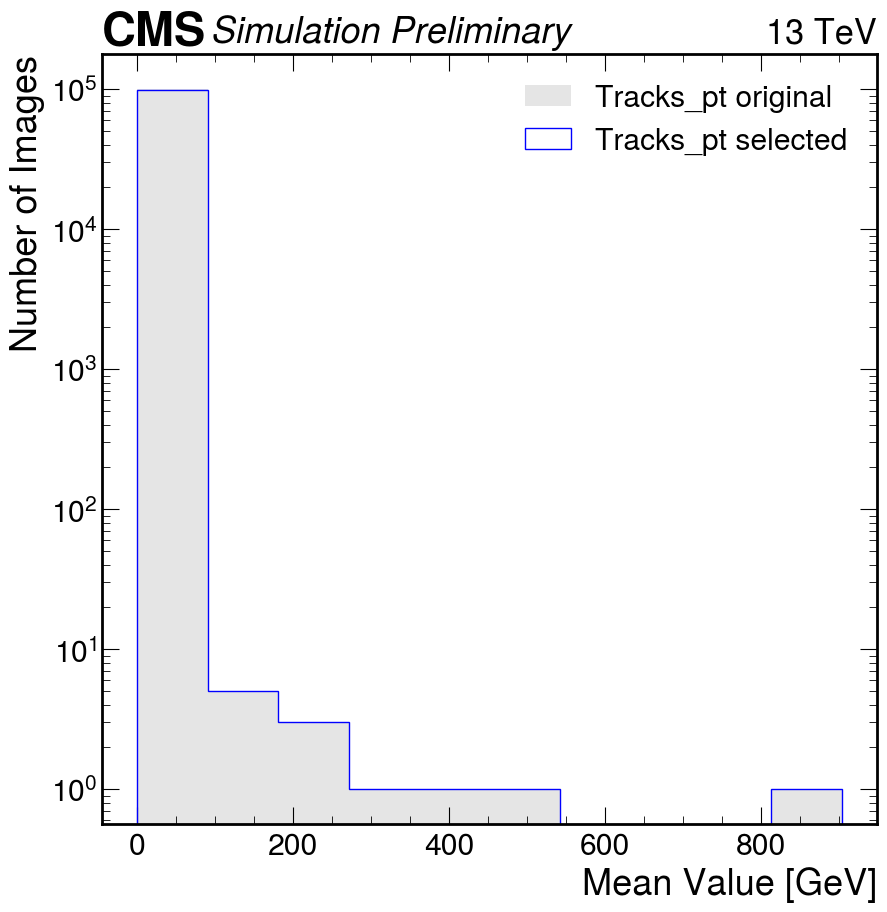

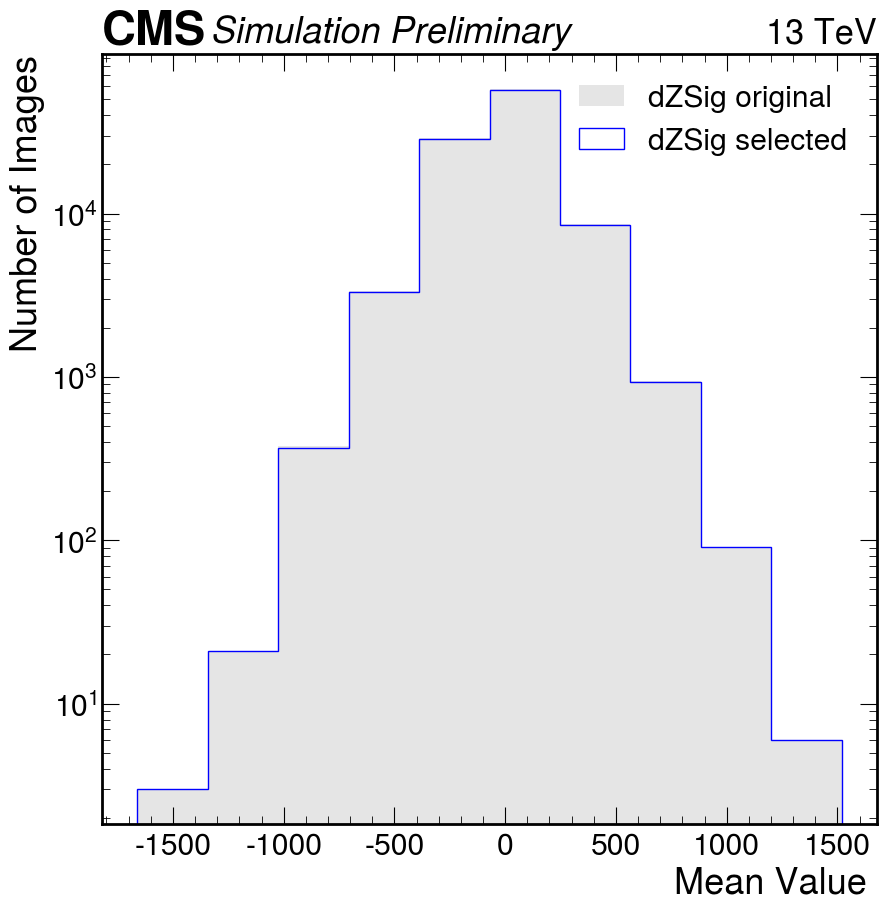

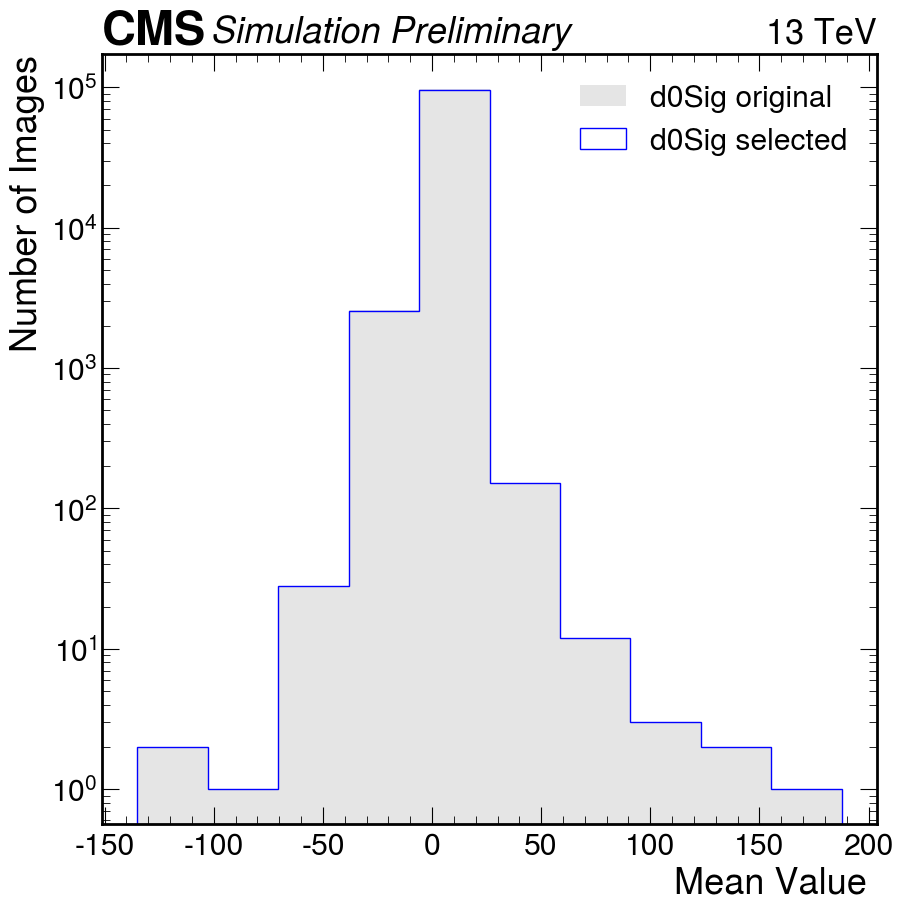

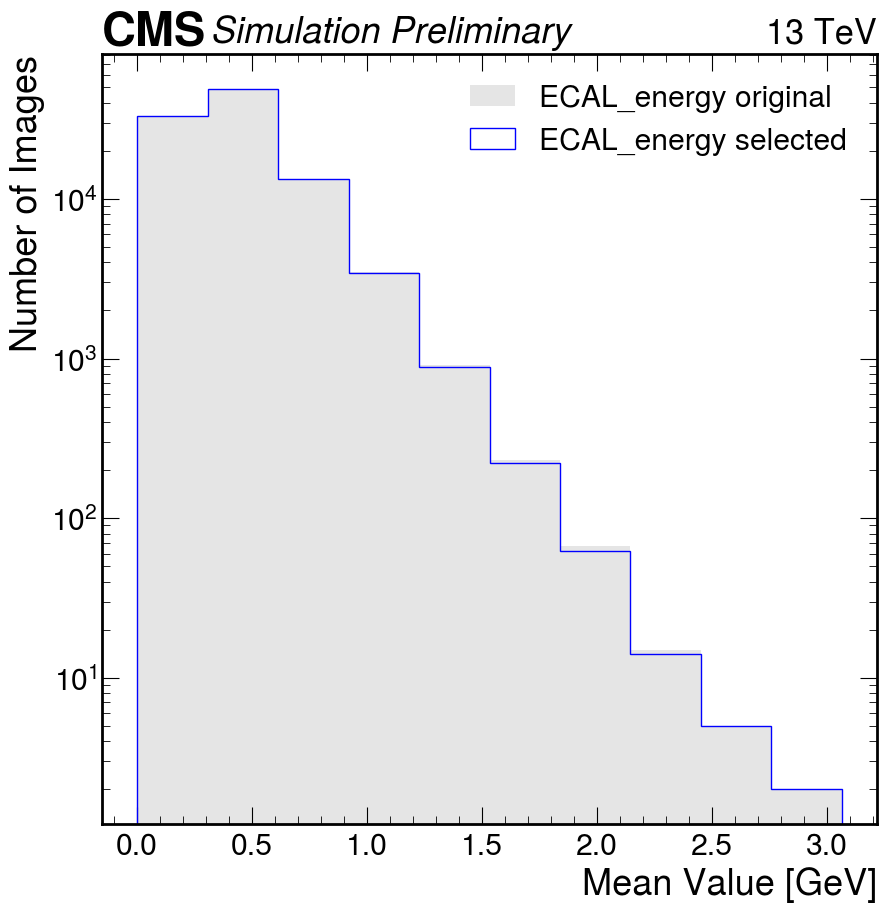

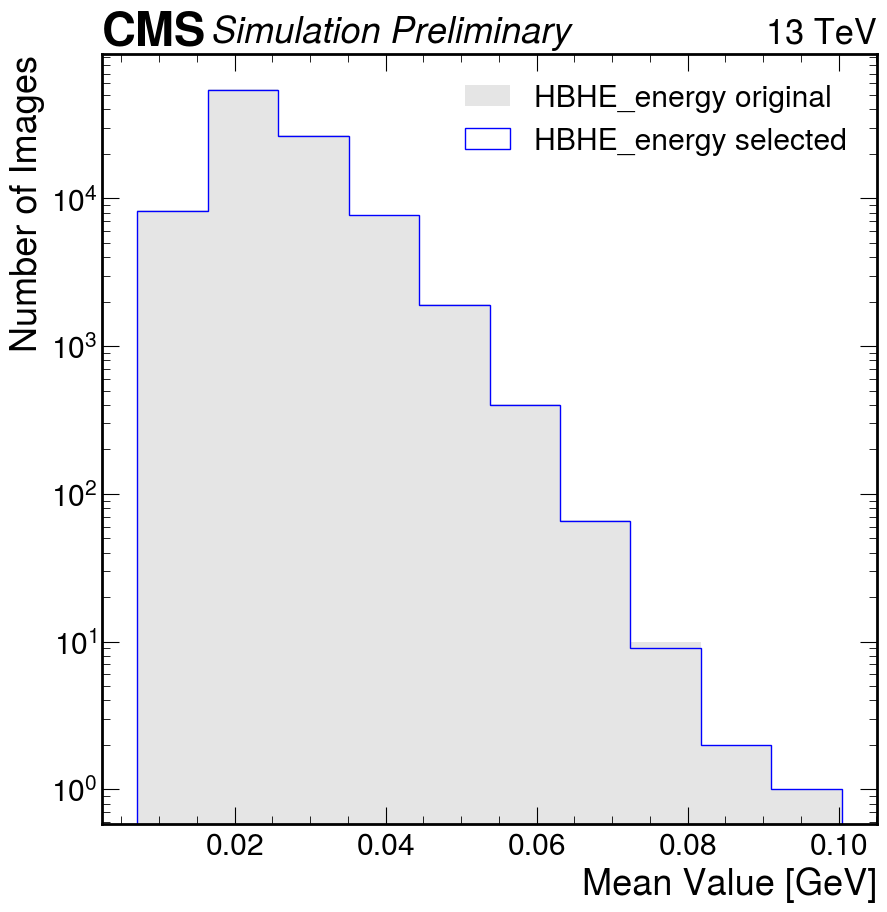

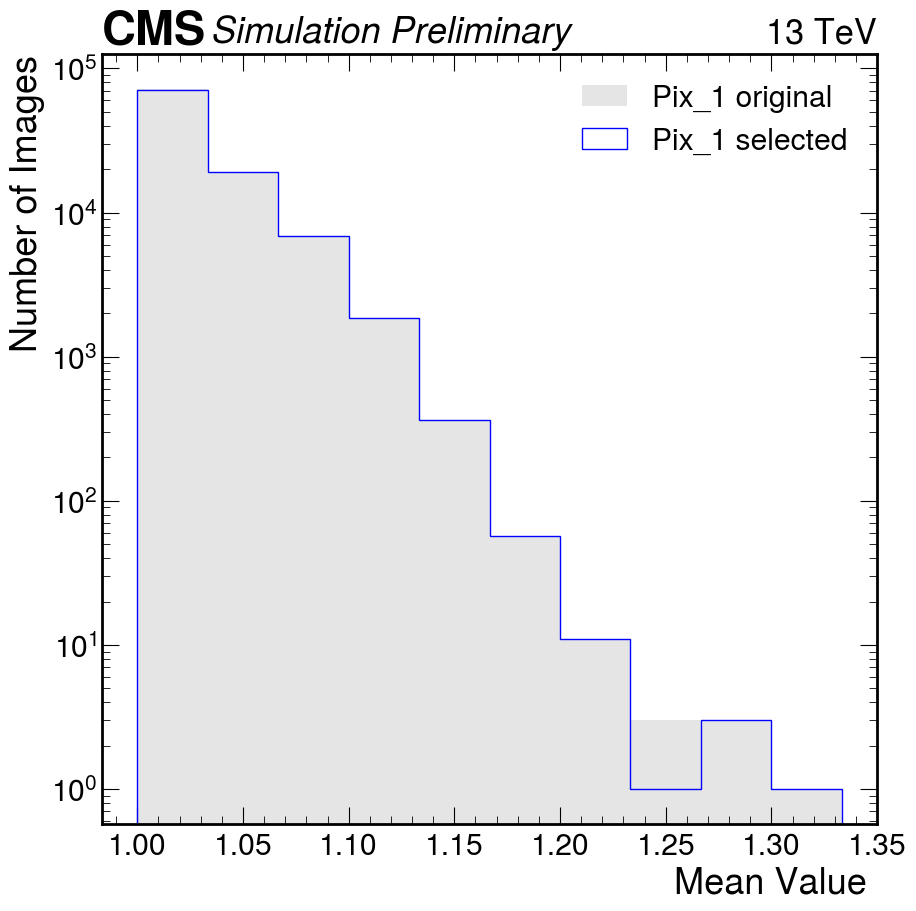

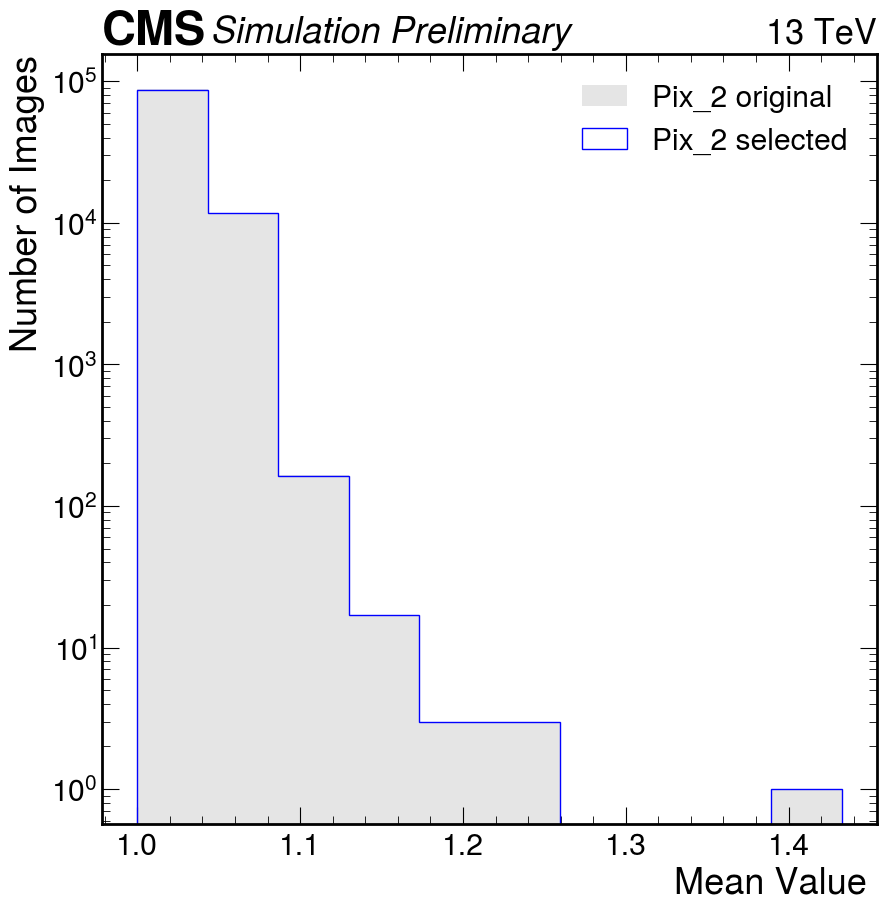

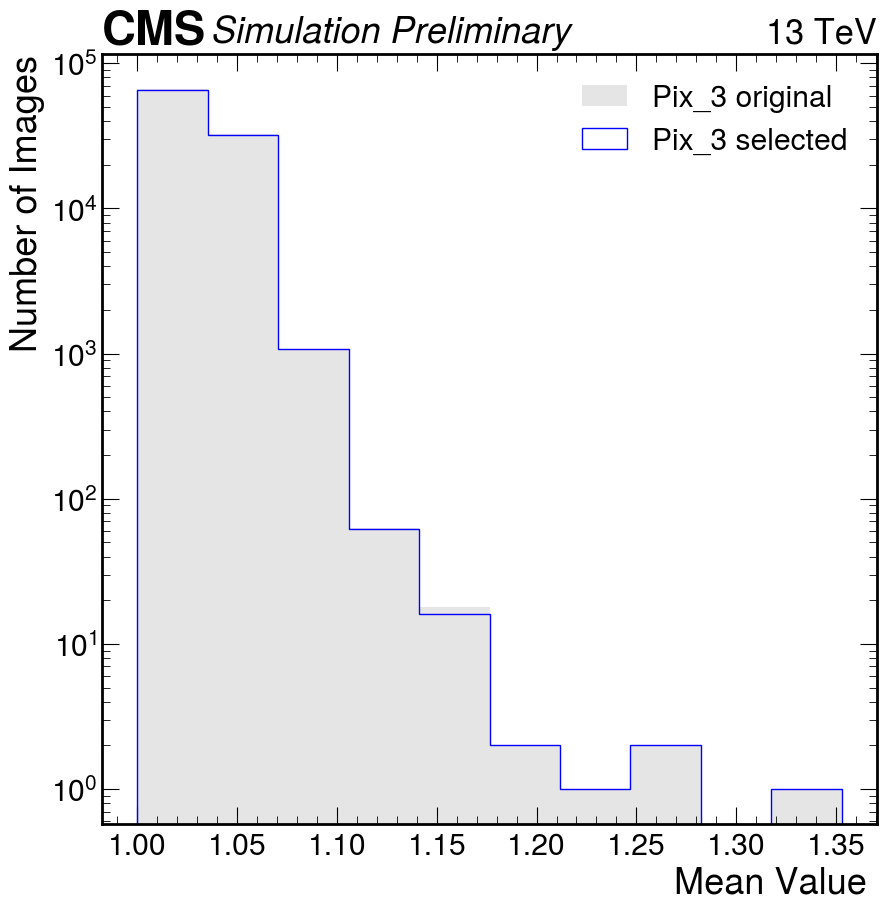

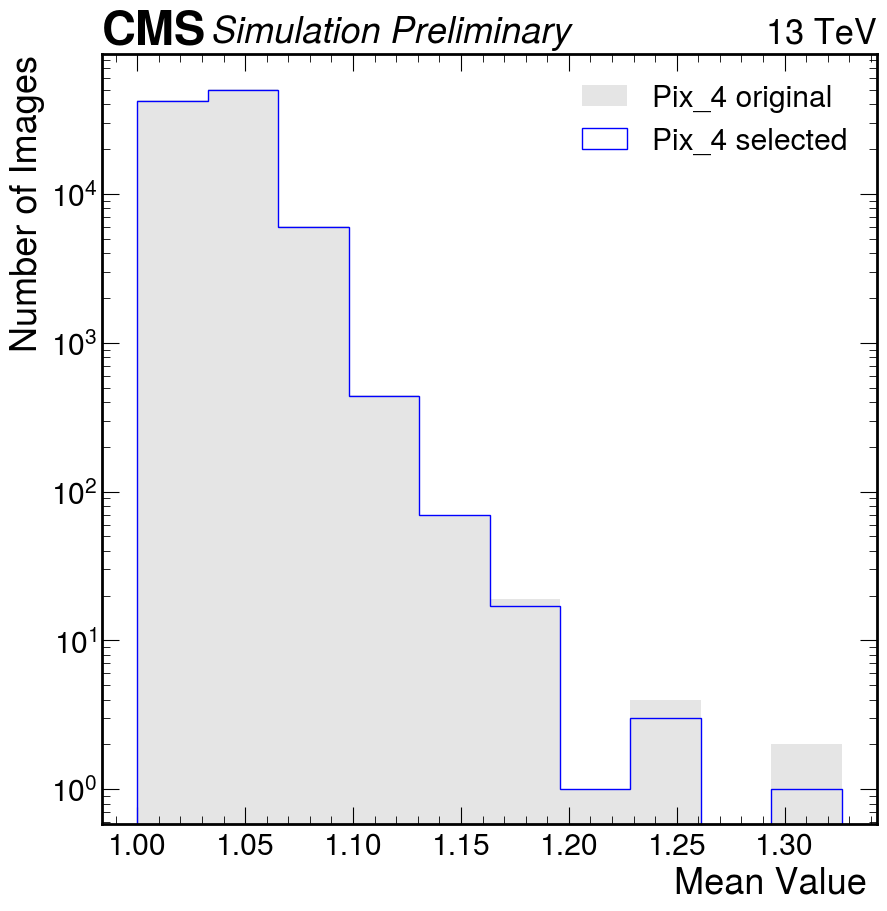

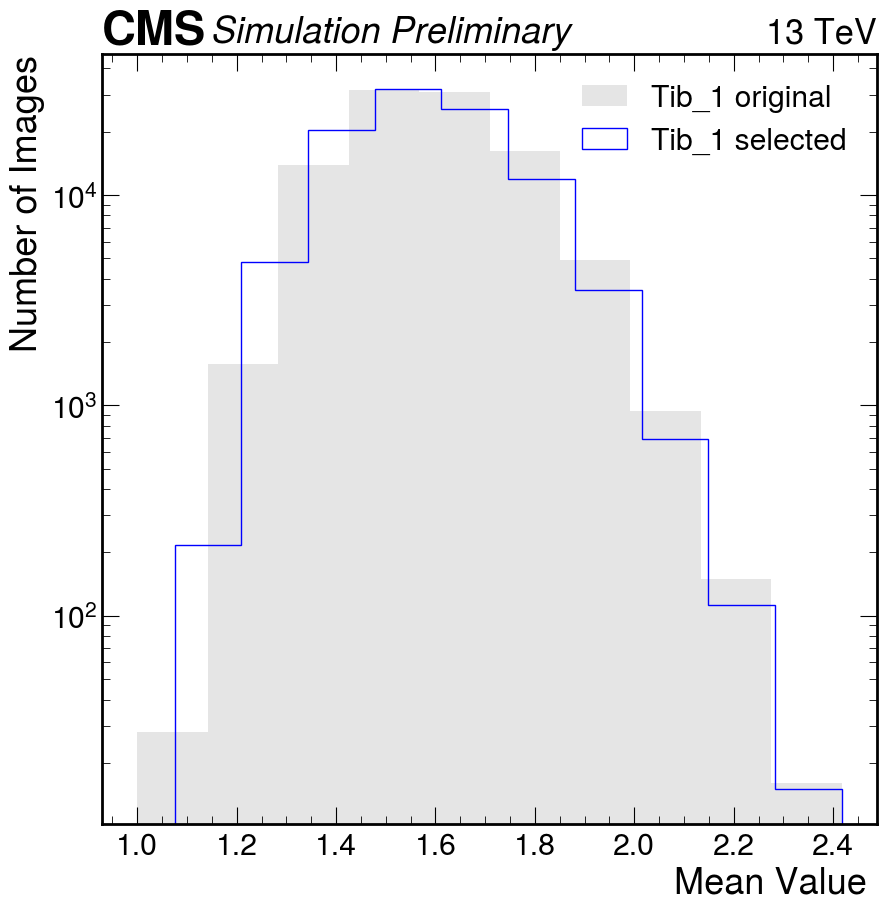

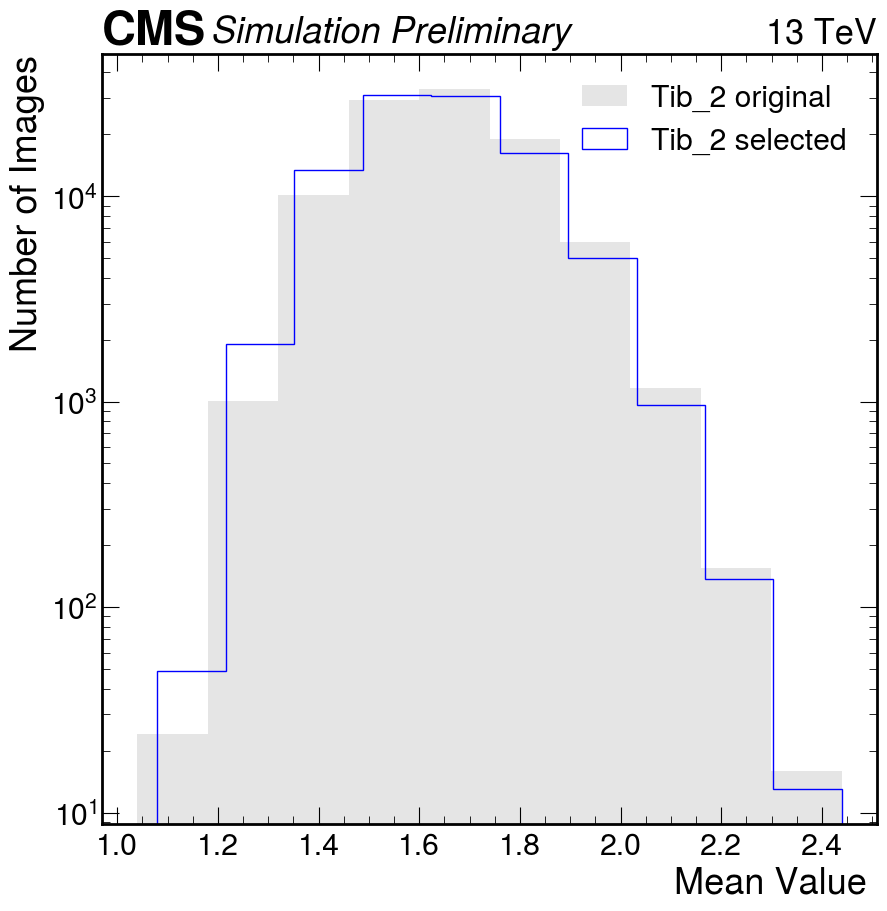

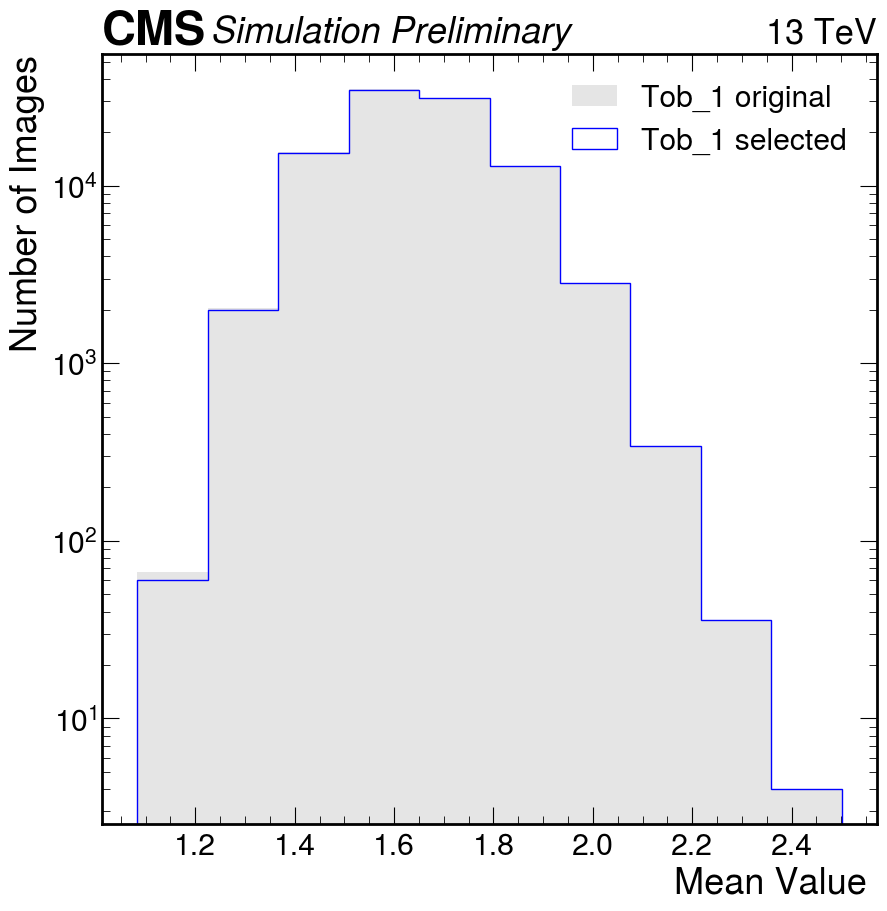

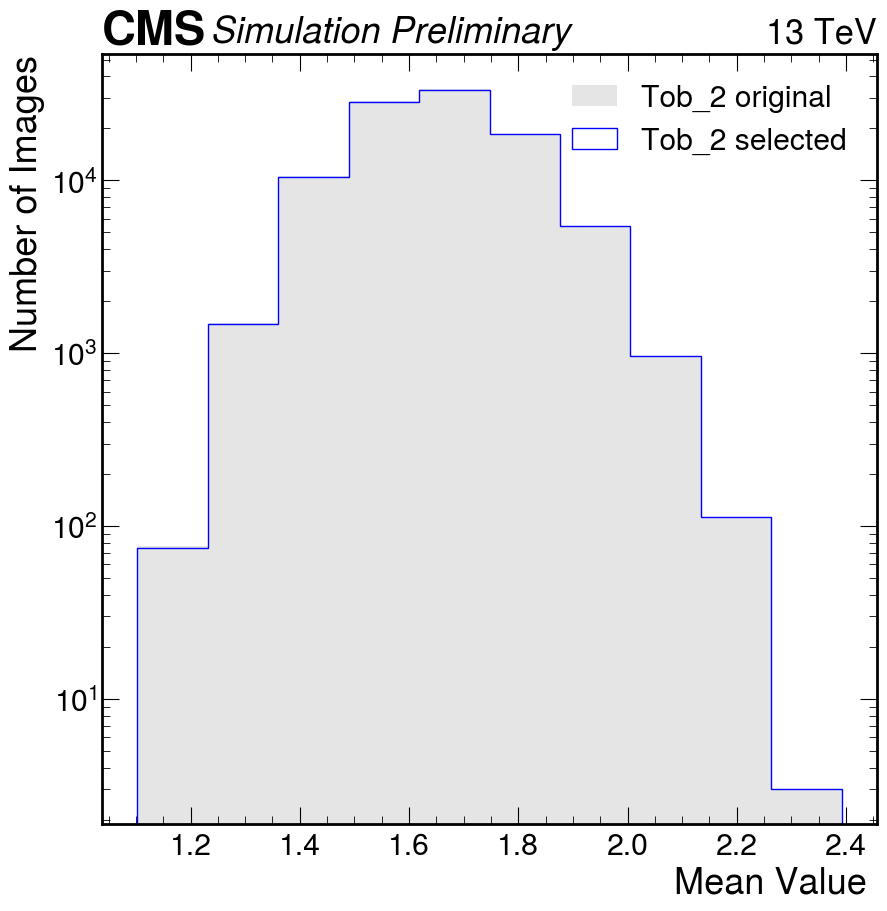

In [5]:
mean_ = []
std_ = []
size_ = []
file_path = glob.glob("mean_std_record_of_original_and_non_outlier_data/*")

channel = ['Tracks_pt', 'dZSig', 'd0Sig', 'ECAL_energy', 'HBHE_energy', 'Pix_1', 'Pix_2', 'Pix_3', 'Pix_4', 'Tib_1', 'Tib_2','Tob_1', 'Tob_2']
with open(file_path[0], 'r') as file:
    data = json.load(file)
    print(data.keys())
nonoutlier_mean = data["nonoutlier_mean"]
orig_mean = data["orig_mean"]

for i in range(13):
    fig, ax = plt.subplots()
    plt.hist(orig_mean[i],color = 'grey', alpha= 0.2, label=f'{channel[i]} original ')
    plt.hist(nonoutlier_mean[i],histtype= 'step', color = 'blue', label=f'{channel[i]} selected')

    # plt.axvline(x=orig_mean[0]+10*orig_std[0], linestyle='--', color='r', label= f'oulier boundery {orig_mean[0]+10*orig_std[0]}')
    if i==1 or i==2 or i>4:
        plt.xlabel('Mean Value ')
    else:
         plt.xlabel('Mean Value [GeV]')
        
    plt.ylabel('Number of Images')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    # plt.grid(True)
    plt.legend()
    plt.yscale('log')
    plt.show()

In [45]:
np.array(nonoutlier_mean).shape

(13, 91269)

In [46]:
np.array(orig_mean).shape

(13, 100000)

### Select outlier images

In [11]:
def h5_outlier(file_):
    
    
    file = file_
    data = h5py.File(f'{file}', 'r')
    num_images = data["all_jet"].shape[0]
    # num_images = 15000
    batch_size = 700
    print(f"processing file ---> {file}\n")
    tag = file.split('_')[-2]

    
    size=704
    print("size : ", size,'\n') 
    outdir = '/pscratch/sd/b/bbbam/outlier_hd5'
    outdir_record = 'mean_std_record_outlier'
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    outfile = f'out_lier_IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_{tag}_train.h5'

    with h5py.File(f'{outdir}/{outfile}', 'w') as proper_data:
        dataset_names = ['all_jet', 'am', 'ieta', 'iphi', 'm0']
        datasets = {
            name: proper_data.create_dataset(
                name,
                (size,13, 125, 125) if 'jet' in name else (size, 1),
                dtype='float32',  # Specify an appropriate data type
                compression='lzf',
                chunks=(batch_size, 13, 125, 125) if 'jet' in name else (1, 1),
            ) for name in dataset_names
        }
        size_ = []
        mean_ = []
        std_ = []
        start_idx_, end_idx_ = 0, 0
        for start_idx in tqdm(range(0, num_images, batch_size)):
            end_idx = min(start_idx + batch_size, num_images)
            images_batch = data["all_jet"][start_idx:end_idx, :, :, :]
            am_batch = data["am"][start_idx:end_idx, :]
            ieta_batch = data["ieta"][start_idx:end_idx, :]
            iphi_batch = data["iphi"][start_idx:end_idx, :]
            m0_batch = data["m0"][start_idx:end_idx, :]
            images_batch[images_batch < 1.e-5] = 0
            non_zero_mask = images_batch != 0
            # print("non_zero_mask.shape  : ", non_zero_mask.shape) 
            images_non_zero = np.where(non_zero_mask, images_batch, np.nan)
            size_channel = np.count_nonzero(non_zero_mask, axis=(2, 3))
            mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
            std_channel = np.nanstd(images_non_zero, axis=(2, 3), ddof=1)
            non_empty_event = np.all(size_channel <= minimum_nonzero_pixels, axis=1)
            
            mean_channel = mean_channel[non_empty_event]
            std_channel = std_channel[non_empty_event]
            size_channel = size_channel[non_empty_event]
            am_batch = am_batch[non_empty_event]
            ieta_batch = ieta_batch[non_empty_event]
            iphi_batch = iphi_batch[non_empty_event]
            m0_batch = m0_batch[non_empty_event]
            images_non_zero = images_non_zero[non_empty_event]

#             # print("images_non_zero.shape before : ", images_non_zero.shape)
#             # print("size_channel.shape. ",size_channel.shape)
#             # print("mean_channel.shape. ",mean_channel.shape)
#             # print("orig_mean.shape.  ", orig_mean.shape)
#             non_outlier_event = np.all(np.logical_and(size_channel > 1, mean_channel < (orig_mean + 10 * orig_std)), axis=1)

#             # print("non_outlier_event.shape : ", non_outlier_event.shape)
#             # print("non_outlier_event : ", non_outlier_event)

#             images_non_zero = images_non_zero[non_empty_event]

#             images_non_zero = images_non_zero[non_outlier_event]
#             am_batch = am_batch[non_outlier_event]
#             ieta_batch = ieta_batch[non_outlier_event]
#             iphi_batch = iphi_batch[non_outlier_event]
#             m0_batch = m0_batch[non_outlier_event]


#             mean_channel = mean_channel[non_outlier_event]
#             std_channel = std_channel[non_outlier_event]
#             size_channel = size_channel[non_outlier_event]


#             images_non_zero = (images_non_zero - after_outlier_mean.reshape(1, 13, 1, 1)) / after_outlier_std.reshape(1, 13, 1, 1)
#             # print("images_non_zero.shape after : ", images_non_zero.shape)
#             mean_channel_ = np.nanmean(images_non_zero, axis=(2, 3))
#             std_channel_ = np.nanstd(images_non_zero, axis=(2, 3), ddof=1)
            size_.append(size_channel)
            mean_.append(mean_channel)
            std_.append(std_channel)
            start_idx_ = min(start_idx, end_idx_)
            end_idx_   = min(start_idx_ + images_non_zero.shape[0], num_images)
            # print("images_non_zero.shape ", images_non_zero.shape[0])


            proper_data['all_jet'][start_idx_:end_idx_,:,:,:] = images_non_zero
            proper_data['am'][start_idx_:end_idx_] = am_batch
            proper_data['ieta'][start_idx_:end_idx_] = ieta_batch
            proper_data['iphi'][start_idx_:end_idx_] = iphi_batch
            proper_data['m0'][start_idx_:end_idx_] = m0_batch
            # print("_____________________________________________________________")

    data.close()
    size_ = np.concatenate(size_, axis=0).T
    mean_ = np.concatenate(mean_, axis=0).T
    std_ = np.concatenate(std_, axis=0).T
    normalised_mean, normalised_std = estimate_population_parameters(size_, mean_, std_)

    print(f'Normalised mean: {normalised_mean}\n' )
    print(f'normalised std : {normalised_std}\n')
    print(f'number_of_selected_jets_std : {std_.shape[1]}\n')

    stat = {
            "outlier_mean":normalised_mean,
            "outlier_std":normalised_std,
            "number_of_selected_jets":std_.shape[1]
            }

    if not os.path.exists(outdir_record):
        os.makedirs(outdir_record)

    with open(outdir_record +'/'+ f'outlier_mean_std_record_dataset_{tag}.json', 'w') as fp:
        json.dump(stat, fp)

    return normalised_mean, normalised_std


In [ ]:
file_list = np.sort(glob.glob("/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_train_hd5/*"))   
h5_outlier(file_list[0])

processing file ---> /pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_train_hd5/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_0000_train.h5

size :  704 



  0%|          | 0/614 [00:00<?, ?it/s]/tmp/ipykernel_1192349/3737423846.py:48: RuntimeWarning: Mean of empty slice
  mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
  8%|▊         | 50/614 [19:38<3:31:00, 22.45s/it]

In [ ]:
def combined_mean_std(size, mean, std):
    mean_ = np.dot(size, mean)/np.sum(size)
    std_ = np.sqrt((np.dot((np.array(size)-1), np.square(std)) + np.dot(size,np.square(mean-mean_)))/(np.sum(size)-1))
    return mean_, std_

mean_ = []
std_ = []
size_ = []
file_path = glob.glob("mean_std_record_original_dataset/*")
for file in file_path:
    with open(file, 'r') as file:
        data = json.load(file)
    mean_.append(data['original_mean'])
    std_.append(data['original_std'])
    size_.append(data['number_of_jets'])
mean = np.array(mean_)
std = np.array(std_)
size = np.array(size_)


orig_mean, orig_std = combined_mean_std(size, mean, std)
print("original mean  :" , orig_mean,"\n")
print("original std  :" , orig_std,"\n")



def h5_h5_normalizes(file_):
    
    num_pass_0 = 0
    num_pass_1 = 0
    num_pass_2 = 0
    
    file = file_
    data = h5py.File(f'{file}', 'r')
    num_images = data["all_jet"].shape[0]
    num_images = 100000
    batch_size = 10000
    print(f"processing file ---> {file}\n")
    tag = file.split('_')[-2]


    outdir = 'mean_std_record_of_original_and_non_outlier_data'
    
    size_orig = []
    mean_orig = []
    std_orig = []
    
    size_ = []
    mean_ = []
    std_ = []
    
    for start_idx in tqdm(range(0, num_images, batch_size)):
        end_idx = min(start_idx + batch_size, num_images)
        images_batch = data["all_jet"][start_idx:end_idx, :, :, :]
        #-----------------------------------------------------------------------------
        non_zero_mask_orig = images_batch != 0
        images_non_zero_orig = np.where(non_zero_mask_orig, images_batch, np.nan)
        size_channel_ = np.count_nonzero(non_zero_mask_orig, axis=(2, 3))
        mean_channel_ = np.nanmean(images_non_zero_orig, axis=(2, 3))
        std_channel_ = np.nanstd(images_non_zero_orig, axis=(2, 3), ddof=1)
        mean_orig.append(mean_channel_)
        std_orig.append(std_channel_)
        size_orig.append(size_channel_)
        num_pass_0 = num_pass_0 + mean_channel_.shape[0]
        #-----------------------------------------------------------------------------
        
        images_batch[np.abs(images_batch) < 1.e-5] = 0
        non_zero_mask = images_batch != 0
        images_non_zero = np.where(non_zero_mask, images_batch, np.nan)
        size_channel = np.count_nonzero(non_zero_mask, axis=(2, 3))
        mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
        std_channel = np.nanstd(images_non_zero, axis=(2, 3), ddof=1)
        non_empty_event = np.all(size_channel > minimum_nonzero_pixels, axis=1)
        mean_channel = mean_channel[non_empty_event]
        std_channel = std_channel[non_empty_event]
        size_channel = size_channel[non_empty_event]
        
        num_pass_1 = num_pass_1 + mean_channel.shape[0]
        
        non_outlier_event = np.all(np.logical_and(size_channel > 1, mean_channel < (orig_mean + 10 * orig_std)), axis=1)
        
        mean_channel = mean_channel[non_outlier_event]
        std_channel = std_channel[non_outlier_event]
        size_channel = size_channel[non_outlier_event]
        
        num_pass_2 = num_pass_2 + mean_channel.shape[0]
        
        
        size_.append(size_channel)
        mean_.append(mean_channel)
        std_.append(std_channel)
        
        

    data.close()
    size_ = np.concatenate(size_, axis=0).T
    mean_ = np.concatenate(mean_, axis=0).T
    std_ = np.concatenate(std_, axis=0).T
    
    size_orig = np.concatenate(size_orig, axis=0).T
    mean_orig = np.concatenate(mean_orig, axis=0).T
    std_orig = np.concatenate(std_orig, axis=0).T
    
    stat = {
            "nonoutlier_mean": mean_.tolist(),
            "nooutlier_std": std_.tolist(),
            "nonoutlier_jets": std_.tolist(),
            "orig_mean": mean_orig.tolist(),
            "orig_std": std_orig.tolist(),
            "orig_size": size_orig.tolist()
            }

    if not os.path.exists(outdir):
        os.makedirs(outdir)

    with open(outdir +'/'+ f'original_mean_std_record_origina_and_non_outlier_dataset_{tag}.json', 'w') as fp:
        json.dump(stat, fp)
    
    print(" num_pass_0 ",  num_pass_0)
    print(" num_pass_1 ",  num_pass_1, (num_pass_0-num_pass_1)/num_pass_0 *100,"%")
    print(" num_pass_2 ",  num_pass_2, (num_pass_1-num_pass_2)/num_pass_1 *100,"%")
    
# print("original", np.array(mean_orig).shape)
# print("non_oulier", np.array(mean_).shape)


In [17]:
def combined_mean_std(size, mean, std):
    mean_ = np.dot(size, mean)/np.sum(size)
    std_ = np.sqrt((np.dot((np.array(size)-1), np.square(std)) + np.dot(size,np.square(mean-mean_)))/(np.sum(size)-1))
    return mean_, std_

mean_ = []
std_ = []
size_ = []
file_path = np.sort(glob.glob("mean_std_record_original_dataset/*"))
for file in file_path:
    with open(file, 'r') as file:
        data = json.load(file)
    mean_.append(data['original_mean'])
    std_.append(data['original_std'])
    size_.append(data['number_of_jets'])
mean = np.array(mean_)
std = np.array(std_)
orig_size = np.array(size_)


orig_mean, orig_std = combined_mean_std(orig_size, mean, std)
print("original mean  :" , orig_mean,"\n")
print("original std  :" , orig_std,"\n")
print("totoal samples  :" , orign_size,"\n")


### Calculate combined mean and std for data after outlier Run this before sonverting to normalised h5-----------------------------------------------------------------------------------------------------------



mean_ = []
std_ = []
size_ = []
file_path = np.sort(glob.glob("mean_std_record_after_outlier/*"))
for file in file_path:
    with open(file, 'r') as file:
        data = json.load(file)
    mean_.append(data['after_outlier_mean'])
    std_.append(data['after_outlier_std'])
    size_.append(data['number_of_selected_jets'])
mean = np.array(mean_)
std = np.array(std_)
size = np.array(size_)


after_outlier_mean, after_outlier_std = combined_mean_std(size, mean, std)
print("after outlier mean  : " , after_outlier_mean,"\n")
print("after outlier std  : " , after_outlier_std,"\n")
print("total selected jets : " , size, "\n")
channel = ['Tracks_pt', 'dZSig', 'd0Sig', 'ECAL_energy', 'HBHE_energy', 'Pix_1', 'Pix_2', 'Pix_3', 'Pix_4', 'Tib_1', 'Tib_2','Tob_1', 'Tob_1']

file="/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_train_hd5/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_0000_train.h5"

minimum_nonzero_pixels=3
print(f"processing file ---> {file}\n")
tag = file.split('_')[-2]
data = h5py.File(file, 'r')


size_ = []
mean_ = []
std_ = []

# num_images = data["all_jet"].shape[0]
# batch_size=20000 
num_images = 55
batch_size =55

num_pass_0 = 0
num_pass_1 = 0
num_pass_2 = 0

print(f"data size: {num_images}\n")
for start_idx in tqdm(range(0, num_images, batch_size)):
    end_idx = min(start_idx + batch_size, num_images)
    images_batch = data["all_jet"][start_idx:end_idx, :, :, :]
    images_batch[images_batch < 1.e-5] = 0
    non_zero_mask = images_batch != 0
    print("images_batch", images_batch.shape)
    # zero_mask = images_batch == 0
    images_non_zero = np.where(non_zero_mask, images_batch, np.nan)
    print("images_non_zero", images_non_zero.shape)
    size_channel = np.count_nonzero(non_zero_mask, axis=(2, 3))
    mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
    std_channel = np.nanstd(images_non_zero, axis=(2, 3), ddof=1)
   
    # print("mean_channel 0  :", mean_channel.shape)
    num_pass_0 = num_pass_0 + mean_channel.shape[0]
   
    
    non_empty_event = np.all(size_channel > minimum_nonzero_pixels, axis=1)
    mean_channel = mean_channel[non_empty_event]
    std_channel = std_channel[non_empty_event]
    size_channel = size_channel[non_empty_event]
    images_non_zero_empty = images_non_zero[non_empty_event]
    # print("mean_channel 1  :", mean_channel.shape)
    num_pass_1 = num_pass_1 + mean_channel.shape[0]
    
    
    non_outlier_event = np.all(np.logical_and(size_channel > 1, mean_channel < (orig_mean + 10 * orig_std)), axis=1)
    outlier_event = np.all(np.logical_or(size_channel <= 1, mean_channel >= (orig_mean + 10 * orig_std)), axis=1)
    size_channel = size_channel[non_outlier_event]
    mean_channel = mean_channel[non_outlier_event]
    std_channel = std_channel[non_outlier_event]
    images_non_zero_empty_outlier = images_non_zero_empty[non_outlier_event]
    images_outlier = images_non_zero_empty[outlier_event]
    print("images_non_zero_empty_outlier", images_non_zero_empty_outlier.shape)
    print("images_outlier", images_outlier.shape)
    # print("mean_channel  2 :", mean_channel.shape)
    num_pass_2 = num_pass_2 + mean_channel.shape[0]
   
    
    size_.append(size_channel)
    mean_.append(mean_channel)
    std_.append(std_channel)

data.close()  
size_ = np.concatenate(size_, axis=0).T
mean_ = np.concatenate(mean_, axis=0).T
std_ = np.concatenate(std_, axis=0).T
print(" num_pass_0 ",  num_pass_0)
print(" num_pass_1 ",  num_pass_1, (num_pass_0-num_pass_1)/num_pass_0 *100,"%")
print(" num_pass_2 ",  num_pass_2, (num_pass_1-num_pass_2)/num_pass_1 *100,"%")
# print("mean_.shape", mean_.shape[1]) 




processing file ---> /pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_train_hd5/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_0000_train.h5

data size: 55



100%|██████████| 1/1 [00:16<00:00, 16.12s/it]

images_batch (55, 13, 125, 125)
images_non_zero (55, 13, 125, 125)
images_non_zero_empty_outlier (49, 13, 125, 125)
images_outlier (0, 13, 125, 125)
 num_pass_0  55
 num_pass_1  49 10.909090909090908 %
 num_pass_2  49 0.0 %


In [10]:
images_non_zero - images_non_zero_empty_outlier

ValueError: operands could not be broadcast together with shapes (55,13,125,125) (49,13,125,125) 

### Calculate mean and std after removel of outliers

In [5]:
# # ### Run only once to calculate the mean and std after outlier removed
# def process_files(file):
#     file_path = file[0]
#     mean_std_after_outlier(file=file_path,outdir = "mean_std_record_after_outlier", batch_size=14000, minimum_nonzero_pixels=3)
    
# file_list = glob.glob("/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_train_hd5/*")   
# args = list(zip(file_list)) 
# with Pool(10) as p:
#     p.map(process_files,args)

### Calculate the comined mean and std of samples after removed outliers as well as original

In [55]:
def combined_mean_std(size, mean, std):
    mean_ = np.dot(size, mean)/np.sum(size)
    std_ = np.sqrt((np.dot((np.array(size)-1), np.square(std)) + np.dot(size,np.square(mean-mean_)))/(np.sum(size)-1))
    return mean_, std_

mean_ = []
std_ = []
size_ = []
file_path = glob.glob("mean_std_record_original_dataset/*")
for file in file_path:
    with open(file, 'r') as file:
        data = json.load(file)
    mean_.append(data['original_mean'])
    std_.append(data['original_std'])
    size_.append(data['number_of_jets'])
mean = np.array(mean_)
std = np.array(std_)
size = np.array(size_)


orig_mean, orig_std = combined_mean_std(size, mean, std)
print("original mean  :" , orig_mean,"\n")
print("original std  :" , orig_std,"\n")
print("totoal samples  :" , size,"\n")


### Calculate combined mean and std for data after outlier Run this before sonverting to normalised h5-----------------------------------------------------------------------------------------------------------



mean_ = []
std_ = []
size_ = []
file_path = glob.glob("mean_std_record_after_outlier/*")
for file in file_path:
    with open(file, 'r') as file:
        data = json.load(file)
    mean_.append(data['after_outlier_mean'])
    std_.append(data['after_outlier_std'])
    size_.append(data['number_of_selected_jets'])
mean = np.array(mean_)
std = np.array(std_)
size = np.array(size_)


after_outlier_mean, after_outlier_std = combined_mean_std(size, mean, std)
print("after outlier mean  : " , after_outlier_mean,"\n")
print("after outlier std  : " , after_outlier_std,"\n")
print("total selected jets : " , size, "\n")

original mean  : [1.96564565e+00 2.08263890e+02 5.58348869e+00 4.31304512e-01
 2.56358780e-02 1.03114537e+00 1.02714137e+00 1.03126102e+00
 1.03864744e+00 1.63181412e+00 1.68669425e+00 1.68518954e+00
 1.68931466e+00] 

original std  : [1.64547331e+02 2.40326927e+02 3.08302240e+01 2.06503512e+00
 8.01002674e-02 1.84443168e-01 1.70208005e-01 1.83686938e-01
 2.07823703e-01 1.00027121e+00 1.09456862e+00 1.08181558e+00
 1.12996825e+00] 

totoal samples  : [419691 419687 438180 419703 419701 429739 431463 428918 419665 428952] 

after outlier mean  :  [1.94187487e+00 2.08261770e+02 5.58177329e+00 4.31304269e-01
 2.56358990e-02 1.03114542e+00 1.02714137e+00 1.03126105e+00
 1.03864745e+00 1.63181452e+00 1.68669463e+00 1.68518982e+00
 1.68931468e+00] 

after outlier std  :  [2.71139741e+01 2.40285633e+02 3.06056467e+01 2.06503835e+00
 8.01002918e-02 1.84443340e-01 1.70208019e-01 1.83687021e-01
 2.07823705e-01 1.00027157e+00 1.09456875e+00 1.08181565e+00
 1.12996794e+00] 

total selected jets : 

### Mean and std estimated with orifinal dataset and after outlier removed

In [2]:
orig_mean  =  np.array([1.96564565e+00, 2.08263890e+02, 5.58348869e+00, 4.31304512e-01,
 2.56358780e-02, 1.03114537e+00, 1.02714137e+00, 1.03126102e+00,
 1.03864744e+00, 1.63181412e+00, 1.68669425e+00, 1.68518954e+00,
 1.68931466e+00]) 

orig_std  =  np.array([1.64547331e+02, 2.40326927e+02, 3.08302240e+01, 2.06503512e+00,
 8.01002674e-02, 1.84443168e-01, 1.70208005e-01, 1.83686938e-01,
 2.07823703e-01, 1.00027121e+00, 1.09456862e+00, 1.08181558e+00,
 1.12996825e+00]) 

totoal_samples  =  np.array([419691, 419687, 438180, 419703, 419701, 429739, 431463, 428918, 419665, 428952]) 

after_outlier_mean  =  np.array([1.94187487e+00, 2.08261770e+02, 5.58177329e+00, 4.31304269e-01,
 2.56358990e-02, 1.03114542e+00, 1.02714137e+00, 1.03126105e+00,
 1.03864745e+00, 1.63181452e+00, 1.68669463e+00, 1.68518982e+00,
 1.68931468e+00]) 

after_outlier_std  =  np.array([2.71139741e+01, 2.40285633e+02, 3.06056467e+01, 2.06503835e+00,
 8.01002918e-02, 1.84443340e-01, 1.70208019e-01, 1.83687021e-01,
 2.07823705e-01, 1.00027157e+00, 1.09456875e+00, 1.08181565e+00,
 1.12996794e+00]) 

after_outlier_selected_jets =  np.array([383216, 400368, 383230, 383125, 391450, 383631, 391998, 393935, 392235, 383309]) 


### Convert h5py file to normalized h5py  m=3.6-14.8 GeV

In [3]:
# file_list = glob.glob("/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_train_hd5/*")
# file_list

In [10]:
def h5_h5_normalizes(file_):
    
    
    file = file_
    data = h5py.File(f'{file}', 'r')
    num_images = data["all_jet"].shape[0]
    # num_images = 15000
    batch_size = 3200
    print(f"processing file ---> {file}\n")
    tag = file.split('_')[-2]

    with open(f'mean_std_record_after_outlier/after_outlier_mean_std_record_dataset_{tag}.json', 'r') as file:
        data_ = json.load(file)
        size=data_['number_of_selected_jets']
    print("size : ", size,'\n') 
    outdir = '/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_normalised_train_hd5'
    outdir_record = 'mean_std_record_of_normalised_dataset'
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    outfile = f'IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_{tag}_normalized_train.h5'

    with h5py.File(f'{outdir}/{outfile}', 'w') as proper_data:
        dataset_names = ['all_jet', 'am', 'ieta', 'iphi', 'm0']
        datasets = {
            name: proper_data.create_dataset(
                name,
                (size,13, 125, 125) if 'jet' in name else (size, 1),
                dtype='float32',  # Specify an appropriate data type
                compression='lzf',
                chunks=(batch_size, 13, 125, 125) if 'jet' in name else (1, 1),
            ) for name in dataset_names
        }
        size_ = []
        mean_ = []
        std_ = []
        start_idx_, end_idx_ = 0, 0
        for start_idx in tqdm(range(0, num_images, batch_size)):
            end_idx = min(start_idx + batch_size, num_images)
            images_batch = data["all_jet"][start_idx:end_idx, :, :, :]
            am_batch = data["am"][start_idx:end_idx, :]
            ieta_batch = data["ieta"][start_idx:end_idx, :]
            iphi_batch = data["iphi"][start_idx:end_idx, :]
            m0_batch = data["m0"][start_idx:end_idx, :]
            images_batch[images_batch < 1.e-5] = 0
            non_zero_mask = images_batch != 0
            # print("non_zero_mask.shape  : ", non_zero_mask.shape) 
            images_non_zero = np.where(non_zero_mask, images_batch, np.nan)
            size_channel = np.count_nonzero(non_zero_mask, axis=(2, 3))
            mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
            std_channel = np.nanstd(images_non_zero, axis=(2, 3), ddof=1)
            non_empty_event = np.all(size_channel > minimum_nonzero_pixels, axis=1)
            mean_channel = mean_channel[non_empty_event]
            std_channel = std_channel[non_empty_event]
            size_channel = size_channel[non_empty_event]
            am_batch = am_batch[non_empty_event]
            ieta_batch = ieta_batch[non_empty_event]
            iphi_batch = iphi_batch[non_empty_event]
            m0_batch = m0_batch[non_empty_event]


            # print("images_non_zero.shape before : ", images_non_zero.shape)
            # print("size_channel.shape. ",size_channel.shape)
            # print("mean_channel.shape. ",mean_channel.shape)
            # print("orig_mean.shape.  ", orig_mean.shape)
            non_outlier_event = np.all(np.logical_and(size_channel > 1, mean_channel < (orig_mean + 10 * orig_std)), axis=1)

            # print("non_outlier_event.shape : ", non_outlier_event.shape)
            # print("non_outlier_event : ", non_outlier_event)

            images_non_zero = images_non_zero[non_empty_event]

            images_non_zero = images_non_zero[non_outlier_event]
            am_batch = am_batch[non_outlier_event]
            ieta_batch = ieta_batch[non_outlier_event]
            iphi_batch = iphi_batch[non_outlier_event]
            m0_batch = m0_batch[non_outlier_event]


            mean_channel = mean_channel[non_outlier_event]
            std_channel = std_channel[non_outlier_event]
            size_channel = size_channel[non_outlier_event]


            images_non_zero = (images_non_zero - after_outlier_mean.reshape(1, 13, 1, 1)) / after_outlier_std.reshape(1, 13, 1, 1)
            # print("images_non_zero.shape after : ", images_non_zero.shape)
            mean_channel_ = np.nanmean(images_non_zero, axis=(2, 3))
            std_channel_ = np.nanstd(images_non_zero, axis=(2, 3), ddof=1)
            size_.append(size_channel)
            mean_.append(mean_channel_)
            std_.append(std_channel_)
            start_idx_ = min(start_idx, end_idx_)
            end_idx_   = min(start_idx_ + images_non_zero.shape[0], num_images)
            # print("images_non_zero.shape ", images_non_zero.shape[0])


            proper_data['all_jet'][start_idx_:end_idx_,:,:,:] = images_non_zero
            proper_data['am'][start_idx_:end_idx_] = am_batch
            proper_data['ieta'][start_idx_:end_idx_] = ieta_batch
            proper_data['iphi'][start_idx_:end_idx_] = iphi_batch
            proper_data['m0'][start_idx_:end_idx_] = m0_batch
            # print("_____________________________________________________________")

    data.close()
    size_ = np.concatenate(size_, axis=0).T
    mean_ = np.concatenate(mean_, axis=0).T
    std_ = np.concatenate(std_, axis=0).T
    normalised_mean, normalised_std = estimate_population_parameters(size_, mean_, std_)

    print(f'Normalised mean: {normalised_mean}\n' )
    print(f'normalised std : {normalised_std}\n')
    print(f'number_of_selected_jets_std : {std_.shape[1]}\n')

    stat = {
            "normalised_mean":normalised_mean,
            "normalised_std":normalised_std,
            "number_of_selected_jets":std_.shape[1]
            }

    if not os.path.exists(outdir_record):
        os.makedirs(outdir_record)

    with open(outdir_record +'/'+ f'normalised_mean_std_record_dataset_{tag}.json', 'w') as fp:
        json.dump(stat, fp)

    return normalised_mean, normalised_std


In [ ]:
# # ### Run only once to convert h5 to nomalized h5
# def process_files(file):
#     file_path = file[0]
#     h5_h5_normalizes(file_path)
    
# file_list = glob.glob("/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_train_hd5/*")   
# args = list(zip(file_list)) 
# with Pool(10) as p:
#     p.map(process_files,args)

### Combined mean and std of normalized h5

In [6]:
def combined_mean_std(size, mean, std):
    mean_ = np.dot(size, mean)/np.sum(size)
    std_ = np.sqrt((np.dot((np.array(size)-1), np.square(std)) + np.dot(size,np.square(mean-mean_)))/(np.sum(size)-1))
    return mean_, std_

mean_ = []
std_ = []
size_ = []
file_path = glob.glob("mean_std_record_of_normalised_dataset/*")
for file in file_path:
    with open(file, 'r') as file:
        data = json.load(file)
    mean_.append(data['normalised_mean'])
    std_.append(data['normalised_std'])
    size_.append(data['number_of_selected_jets'])
mean = np.array(mean_)
std = np.array(std_)
size = np.array(size_)


orig_mean, orig_std = combined_mean_std(size, mean, std)
print("normalized mean  :" , orig_mean,"\n")
print("normalized std  :" , orig_std,"\n")
print("normalized samples  :" , size,"\n")


normalized mean  : [-9.21945432e-11  8.18440931e-10  7.09693327e-11  7.63649170e-11
 -4.78024959e-10 -1.05494582e-08  1.95686408e-08  2.32925453e-08
 -1.23615015e-09  4.07365599e-09 -1.50545800e-09 -2.90092283e-09
 -4.44566585e-10] 

normalized std  : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 

normalized samples  : [383216 383631 393935 383125 392235 400368 391998 383230 383309 391450] 



## For massregression data m=1.2-3.6GeV and m=14.8-17.2 GeV pseudoscalar mass


### First calculate number of event passed to outlier cut , here only final count needed

In [6]:
orig_mean  =  np.array([1.96564565e+00, 2.08263890e+02, 5.58348869e+00, 4.31304512e-01,
 2.56358780e-02, 1.03114537e+00, 1.02714137e+00, 1.03126102e+00,
 1.03864744e+00, 1.63181412e+00, 1.68669425e+00, 1.68518954e+00,
 1.68931466e+00]) 

orig_std  =  np.array([1.64547331e+02, 2.40326927e+02, 3.08302240e+01, 2.06503512e+00,
 8.01002674e-02, 1.84443168e-01, 1.70208005e-01, 1.83686938e-01,
 2.07823703e-01, 1.00027121e+00, 1.09456862e+00, 1.08181558e+00,
 1.12996825e+00]) 

totoal_samples  =  np.array([419691, 419687, 438180, 419703, 419701, 429739, 431463, 428918, 419665, 428952]) 

after_outlier_mean  =  np.array([1.94187487e+00, 2.08261770e+02, 5.58177329e+00, 4.31304269e-01,
 2.56358990e-02, 1.03114542e+00, 1.02714137e+00, 1.03126105e+00,
 1.03864745e+00, 1.63181452e+00, 1.68669463e+00, 1.68518982e+00,
 1.68931468e+00]) 

after_outlier_std  =  np.array([2.71139741e+01, 2.40285633e+02, 3.06056467e+01, 2.06503835e+00,
 8.01002918e-02, 1.84443340e-01, 1.70208019e-01, 1.83687021e-01,
 2.07823705e-01, 1.00027157e+00, 1.09456875e+00, 1.08181565e+00,
 1.12996794e+00]) 

after_outlier_selected_jets =  np.array([383216, 400368, 383230, 383125, 391450, 383631, 391998, 393935, 392235, 383309]) 



def mean_std_after_outlier(file="/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_train_hd5/IMG_aToTauTau_Hadronic_tauDR0p4_m3p6To14p8_dataset_2_unbaised_v2_0000_train.h5",outdir="number_of_event_passed_outlier_cut_m14p8To17p2", batch_size=20000, minimum_nonzero_pixels=3):
    print(f"processing file ---> {file}\n")
    tag = file.split('_')[-2]
    data = h5py.File(file, 'r')
    num_images = data["all_jet"].shape[0]
    print(f"data size: {num_images}\n")
    size_ = []
    mean_ = []
    std_ = []
   

    for start_idx in tqdm(range(0, num_images, batch_size)):
        end_idx = min(start_idx + batch_size, num_images)
        images_batch = data["all_jet"][start_idx:end_idx, :, :, :]
        # print("start_idx : ", start_idx)
        # print("end_idx : ", end_idx)
        # print("images_batch before :",images_batch.shape)
        images_batch[images_batch < 1.e-5] = 0
        non_zero_mask = images_batch != 0
        # print("non_zero_mask", non_zero_mask)
        images_non_zero = np.where(non_zero_mask, images_batch, np.nan)
        size_channel = np.count_nonzero(non_zero_mask, axis=(2, 3))
        mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
        std_channel = np.nanstd(images_non_zero, axis=(2, 3), ddof=1)
        non_empty_event = np.all(size_channel > minimum_nonzero_pixels, axis=1)
        mean_channel = mean_channel[non_empty_event]
        std_channel = std_channel[non_empty_event]
        size_channel = size_channel[non_empty_event]
        # print("mean_channel   :", mean_channel.shape)
       
        # print("orig_mean   :", orig_mean.shape)
        # non_outlier_event = np.all(size_channel > 1 and mean_channel < (np.tile(orig_mean, (batch_size, 1)) + 10 * np.tile(orig_std, (batch_size, 1))), axis=1)
        non_outlier_event = np.all(np.logical_and(size_channel > 1, mean_channel < (orig_mean + 10 * orig_std)), axis=1)
        size_channel = size_channel[non_outlier_event]
        mean_channel = mean_channel[non_outlier_event]
        std_channel = std_channel[non_outlier_event]
        # print("size_channel  after :", size_channel.shape)
        size_.append(size_channel)
        mean_.append(mean_channel)
        std_.append(std_channel)

    data.close()  
    size_ = np.concatenate(size_, axis=0).T
    mean_ = np.concatenate(mean_, axis=0).T
    std_ = np.concatenate(std_, axis=0).T
    after_outlier_mean, after_outlier_std = estimate_population_parameters(size_, mean_, std_)

    print(f'Means with out outliers: {after_outlier_mean}\n' )
    print(f'Stds with out outliers : { after_outlier_std}\n')
    print(f'number_of_selected_jets_std : {std_.shape[1]}\n')
   

    stat = {
            "after_outlier_mean":after_outlier_mean,
            "after_outlier_std":after_outlier_std,
            "number_of_selected_jets":std_.shape[1]
            }

    if not os.path.exists(outdir):
        os.makedirs(outdir)

    with open(outdir +'/'+ f'after_outlier_mean_std_record_dataset_{tag}.json', 'w') as fp:
        json.dump(stat, fp)
    
    return after_outlier_mean, after_outlier_std


In [12]:
# # # ### Run only once to calculate the mean and std after outlier removed
# def process_files(file):
#     file_path = file[0]
#     mean_std_after_outlier(file=file_path,outdir = "number_of_event_passed_outlier_cut_m1p2To3p6", batch_size=14000, minimum_nonzero_pixels=3)
    
# file_list = glob.glob("/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m1p2To3p6_dataset_2_unbaised_v2_train_hd5/*")   
# # print(file_list)
# args = list(zip(file_list)) 
# with Pool(10) as p:
#     p.map(process_files,args)


### convert to normalised h5 M= 14.8-17.2 GeV and M = 1.2-3.6 GeV

In [15]:
def h5_h5_normalizes(file_):
    
    orig_mean  =  np.array([1.96564565e+00, 2.08263890e+02, 5.58348869e+00, 4.31304512e-01,
     2.56358780e-02, 1.03114537e+00, 1.02714137e+00, 1.03126102e+00,
     1.03864744e+00, 1.63181412e+00, 1.68669425e+00, 1.68518954e+00,
     1.68931466e+00]) 

    orig_std  =  np.array([1.64547331e+02, 2.40326927e+02, 3.08302240e+01, 2.06503512e+00,
     8.01002674e-02, 1.84443168e-01, 1.70208005e-01, 1.83686938e-01,
     2.07823703e-01, 1.00027121e+00, 1.09456862e+00, 1.08181558e+00,
     1.12996825e+00]) 

    

    after_outlier_mean  =  np.array([1.94187487e+00, 2.08261770e+02, 5.58177329e+00, 4.31304269e-01,
     2.56358990e-02, 1.03114542e+00, 1.02714137e+00, 1.03126105e+00,
     1.03864745e+00, 1.63181452e+00, 1.68669463e+00, 1.68518982e+00,
     1.68931468e+00]) 

    after_outlier_std  =  np.array([2.71139741e+01, 2.40285633e+02, 3.06056467e+01, 2.06503835e+00,
     8.01002918e-02, 1.84443340e-01, 1.70208019e-01, 1.83687021e-01,
     2.07823705e-01, 1.00027157e+00, 1.09456875e+00, 1.08181565e+00,
     1.12996794e+00]) 

     
    
    file = file_
    data = h5py.File(f'{file}', 'r')
    num_images = data["all_jet"].shape[0]
    # num_images = 15000
    batch_size = 3200
    print(f"processing file ---> {file}\n")
    tag = file.split('_')[-2]

    with open(f'number_of_event_passed_outlier_cut_m1p2To3p6/after_outlier_mean_std_record_dataset_{tag}.json', 'r') as file:
        data_ = json.load(file)
        size=data_['number_of_selected_jets']
    print("size : ", size,'\n') 
    outdir = '/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m1p2To3p6_dataset_2_unbaised_v2_normalised_train_hd5'
    outdir_record = 'mean_std_record_of_normalised_dataset_m1p2To3p6'
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    outfile = f'IMG_aToTauTau_Hadronic_tauDR0p4_m1p2To3p6_dataset_2_unbaised_v2_{tag}_normalized_train.h5'

    with h5py.File(f'{outdir}/{outfile}', 'w') as proper_data:
        dataset_names = ['all_jet', 'am', 'ieta', 'iphi', 'm0']
        datasets = {
            name: proper_data.create_dataset(
                name,
                (size,13, 125, 125) if 'jet' in name else (size, 1),
                dtype='float32',  # Specify an appropriate data type
                compression='lzf',
                chunks=(batch_size, 13, 125, 125) if 'jet' in name else (1, 1),
            ) for name in dataset_names
        }
        size_ = []
        mean_ = []
        std_ = []
        start_idx_, end_idx_ = 0, 0
        for start_idx in tqdm(range(0, num_images, batch_size)):
            end_idx = min(start_idx + batch_size, num_images)
            images_batch = data["all_jet"][start_idx:end_idx, :, :, :]
            am_batch = data["am"][start_idx:end_idx, :]
            ieta_batch = data["ieta"][start_idx:end_idx, :]
            iphi_batch = data["iphi"][start_idx:end_idx, :]
            m0_batch = data["m0"][start_idx:end_idx, :]
            images_batch[images_batch < 1.e-5] = 0
            non_zero_mask = images_batch != 0
            # print("non_zero_mask.shape  : ", non_zero_mask.shape) 
            images_non_zero = np.where(non_zero_mask, images_batch, np.nan)
            size_channel = np.count_nonzero(non_zero_mask, axis=(2, 3))
            mean_channel = np.nanmean(images_non_zero, axis=(2, 3))
            std_channel = np.nanstd(images_non_zero, axis=(2, 3), ddof=1)
            non_empty_event = np.all(size_channel > minimum_nonzero_pixels, axis=1)
            mean_channel = mean_channel[non_empty_event]
            std_channel = std_channel[non_empty_event]
            size_channel = size_channel[non_empty_event]
            am_batch = am_batch[non_empty_event]
            ieta_batch = ieta_batch[non_empty_event]
            iphi_batch = iphi_batch[non_empty_event]
            m0_batch = m0_batch[non_empty_event]


            # print("images_non_zero.shape before : ", images_non_zero.shape)
            # print("size_channel.shape. ",size_channel.shape)
            # print("mean_channel.shape. ",mean_channel.shape)
            # print("orig_mean.shape.  ", orig_mean.shape)
            non_outlier_event = np.all(np.logical_and(size_channel > 1, mean_channel < (orig_mean + 10 * orig_std)), axis=1)

            # print("non_outlier_event.shape : ", non_outlier_event.shape)
            # print("non_outlier_event : ", non_outlier_event)

            images_non_zero = images_non_zero[non_empty_event]

            images_non_zero = images_non_zero[non_outlier_event]
            am_batch = am_batch[non_outlier_event]
            ieta_batch = ieta_batch[non_outlier_event]
            iphi_batch = iphi_batch[non_outlier_event]
            m0_batch = m0_batch[non_outlier_event]


            mean_channel = mean_channel[non_outlier_event]
            std_channel = std_channel[non_outlier_event]
            size_channel = size_channel[non_outlier_event]


            images_non_zero = (images_non_zero - after_outlier_mean.reshape(1, 13, 1, 1)) / after_outlier_std.reshape(1, 13, 1, 1)
            # print("images_non_zero.shape after : ", images_non_zero.shape)
            mean_channel_ = np.nanmean(images_non_zero, axis=(2, 3))
            std_channel_ = np.nanstd(images_non_zero, axis=(2, 3), ddof=1)
            size_.append(size_channel)
            mean_.append(mean_channel_)
            std_.append(std_channel_)
            start_idx_ = min(start_idx, end_idx_)
            end_idx_   = min(start_idx_ + images_non_zero.shape[0], num_images)
            # print("images_non_zero.shape ", images_non_zero.shape[0])


            proper_data['all_jet'][start_idx_:end_idx_,:,:,:] = images_non_zero
            proper_data['am'][start_idx_:end_idx_] = am_batch
            proper_data['ieta'][start_idx_:end_idx_] = ieta_batch
            proper_data['iphi'][start_idx_:end_idx_] = iphi_batch
            proper_data['m0'][start_idx_:end_idx_] = m0_batch
            # print("_____________________________________________________________")

    data.close()
    size_ = np.concatenate(size_, axis=0).T
    mean_ = np.concatenate(mean_, axis=0).T
    std_ = np.concatenate(std_, axis=0).T
    normalised_mean, normalised_std = estimate_population_parameters(size_, mean_, std_)

    print(f'Normalised mean: {normalised_mean}\n' )
    print(f'normalised std : {normalised_std}\n')
    print(f'number_of_selected_jets_std : {std_.shape[1]}\n')

    stat = {
            "normalised_mean":normalised_mean,
            "normalised_std":normalised_std,
            "number_of_selected_jets":std_.shape[1]
            }

    if not os.path.exists(outdir_record):
        os.makedirs(outdir_record)

    with open(outdir_record +'/'+ f'normalised_mean_std_record_dataset_{tag}.json', 'w') as fp:
        json.dump(stat, fp)

    return normalised_mean, normalised_std


In [1]:

# # ### Run only once to convert h5 to nomalized h5
# def process_files(file):
#     file_path = file[0]
#     h5_h5_normalizes(file_path)
    
# file_list = glob.glob("/pscratch/sd/b/bbbam/IMG_aToTauTau_Hadronic_tauDR0p4_m1p2To3p6_dataset_2_unbaised_v2_train_hd5/*")   
# args = list(zip(file_list)) 
# with Pool(10) as p:
#     p.map(process_files,args)

#  Plots for man and std

In [39]:
def combined_mean_std(size, mean, std):
    mean_ = np.dot(size, mean)/np.sum(size)
    std_ = np.sqrt((np.dot((np.array(size)-1), np.square(std)) + np.dot(size,np.square(mean-mean_)))/(np.sum(size)-1))
    return mean_, std_

mean_ = []
std_ = []
size_ = []
file_path = glob.glob("mean_std_record_original_dataset/*")
for file in file_path:
    with open(file, 'r') as file:
        data = json.load(file)
    mean_.append(data['original_mean'])
    std_.append(data['original_std'])
    size_.append(data['number_of_jets'])
mean = np.array(mean_)
std = np.array(std_)
size = np.array(size_)


orig_mean, orig_std = combined_mean_std(size, mean, std)
print("original mean  :" , orig_mean,"\n")
print("original std  :" , orig_std,"\n")
print("original number of jet. ", np.sum(size),'\n')

mean_ = []
std_ = []
size_ = []
file_path = glob.glob("mean_std_record_after_outlier/*")
for file in file_path:
    with open(file, 'r') as file:
        data = json.load(file)
    # print(data.keys())
    mean_.append(data['after_outlier_mean'])
    std_.append(data['after_outlier_std'])
    size_.append(data['number_of_selected_jets'])
mean = np.array(mean_)
std = np.array(std_)
size = np.array(size_)

after_outlier_mean, after_outlier_std = combined_mean_std(size, mean, std)
print("after outlier mean  :" , after_outlier_mean,"\n")
print("after outlier std  :" , after_outlier_std,"\n")
print("after outlier cut number of jet. ", np.sum(size),'\n')

mean_ = []
std_ = []
size_ = []
file_path = glob.glob("mean_std_record_of_normalised_dataset/*")
for file in file_path:
    with open(file, 'r') as file:
        data = json.load(file)
    # print(data.keys())
    mean_.append(data['normalised_mean'])
    std_.append(data['normalised_std'])
    size_.append(data['number_of_selected_jets'])
mean = np.array(mean_)
std = np.array(std_)
size = np.array(size_)

normalised_mean, normalised_std = combined_mean_std(size, mean, std)
print("normalised_mean  :" , normalised_mean,"\n")
print("normalised_std  :" , normalised_std,"\n")
print("normalised number of jet. ", np.sum(size),'\n')

original mean  : [1.96564565e+00 2.08263890e+02 5.58348869e+00 4.31304512e-01
 2.56358780e-02 1.03114537e+00 1.02714137e+00 1.03126102e+00
 1.03864744e+00 1.63181412e+00 1.68669425e+00 1.68518954e+00
 1.68931466e+00] 

original std  : [1.64547331e+02 2.40326927e+02 3.08302240e+01 2.06503512e+00
 8.01002674e-02 1.84443168e-01 1.70208005e-01 1.83686938e-01
 2.07823703e-01 1.00027121e+00 1.09456862e+00 1.08181558e+00
 1.12996825e+00] 

original number of jet.  4255699 

after outlier mean  : [1.94187487e+00 2.08261770e+02 5.58177329e+00 4.31304269e-01
 2.56358990e-02 1.03114542e+00 1.02714137e+00 1.03126105e+00
 1.03864745e+00 1.63181452e+00 1.68669463e+00 1.68518982e+00
 1.68931468e+00] 

after outlier std  : [2.71139741e+01 2.40285633e+02 3.06056467e+01 2.06503835e+00
 8.01002918e-02 1.84443340e-01 1.70208019e-01 1.83687021e-01
 2.07823705e-01 1.00027157e+00 1.09456875e+00 1.08181565e+00
 1.12996794e+00] 

after outlier cut number of jet.  3886497 

normalised_mean  : [-9.21945432e-11  

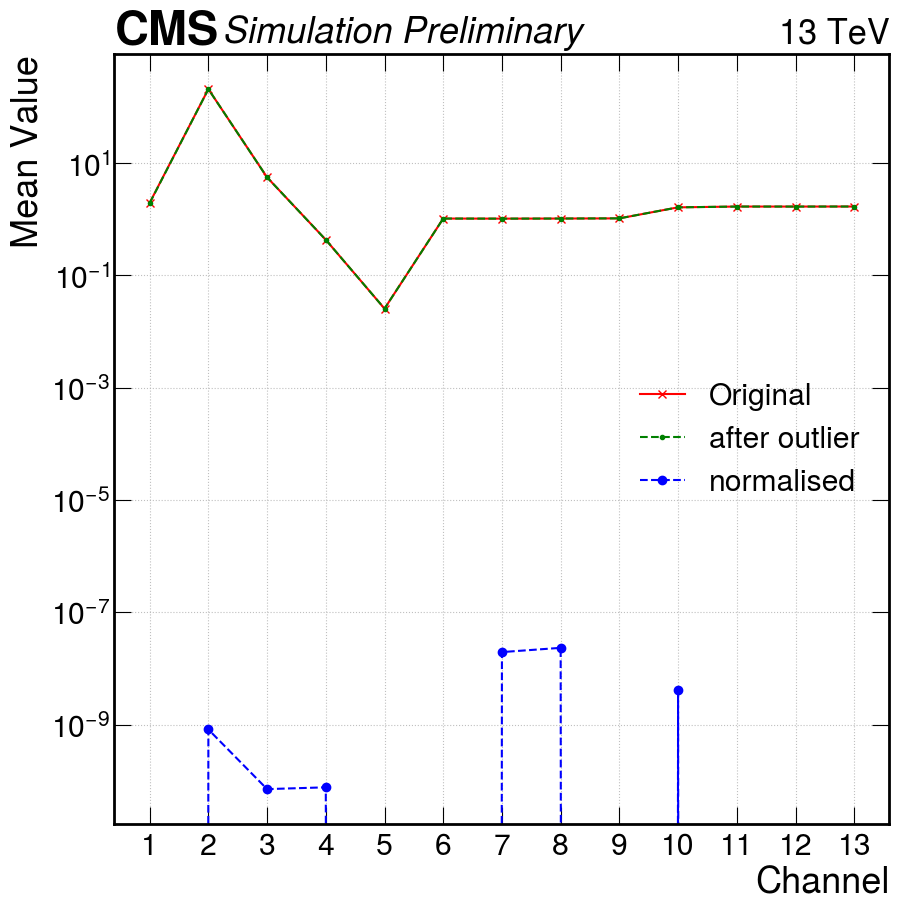

In [76]:

Channels = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

# Plotting
fig, ax = plt.subplots()
plt.plot(Channels, orig_mean, marker='x',color = 'r',label='Original')
plt.plot(Channels, after_outlier_mean, marker='.', linestyle='--', color = 'g',label='after outlier')
plt.plot(Channels, normalised_mean, marker='o', linestyle='--', color = 'b',label='normalised')
plt.xlabel('Channel')
plt.xticks(np.arange(1, 14, 1))
plt.ylabel('Mean Value')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
plt.grid(True)
plt.minorticks_off()
plt.legend()
plt.yscale('log')
plt.show()


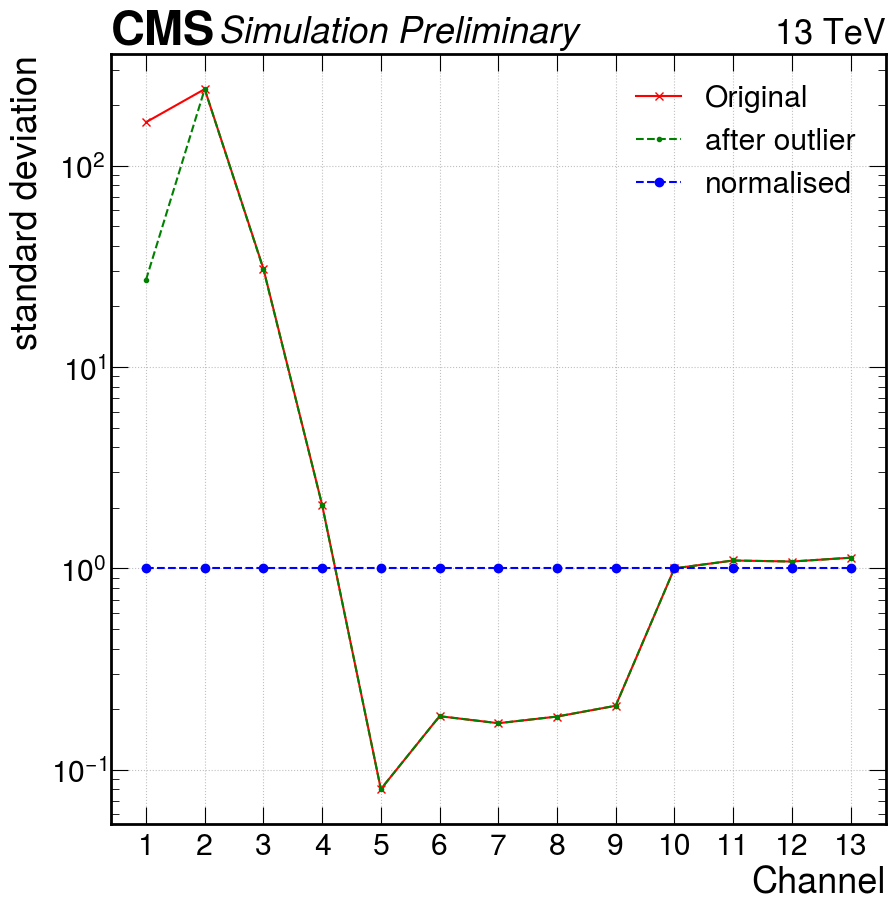

In [72]:

Channels = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

# Plotting
fig, ax = plt.subplots()
plt.plot(Channels, orig_std, marker='x',color = 'r',label='Original')
plt.plot(Channels, after_outlier_std, marker='.', linestyle='--', color = 'g',label='after outlier')
plt.plot(Channels, normalised_std, marker='o', linestyle='--', color = 'b',label='normalised')
plt.xlabel('Channel')
plt.xticks(np.arange(1, 14, 1))
plt.ylabel('standard deviation')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
plt.grid(True)
plt.minorticks_off()
plt.legend()
plt.yscale('log')
plt.show()


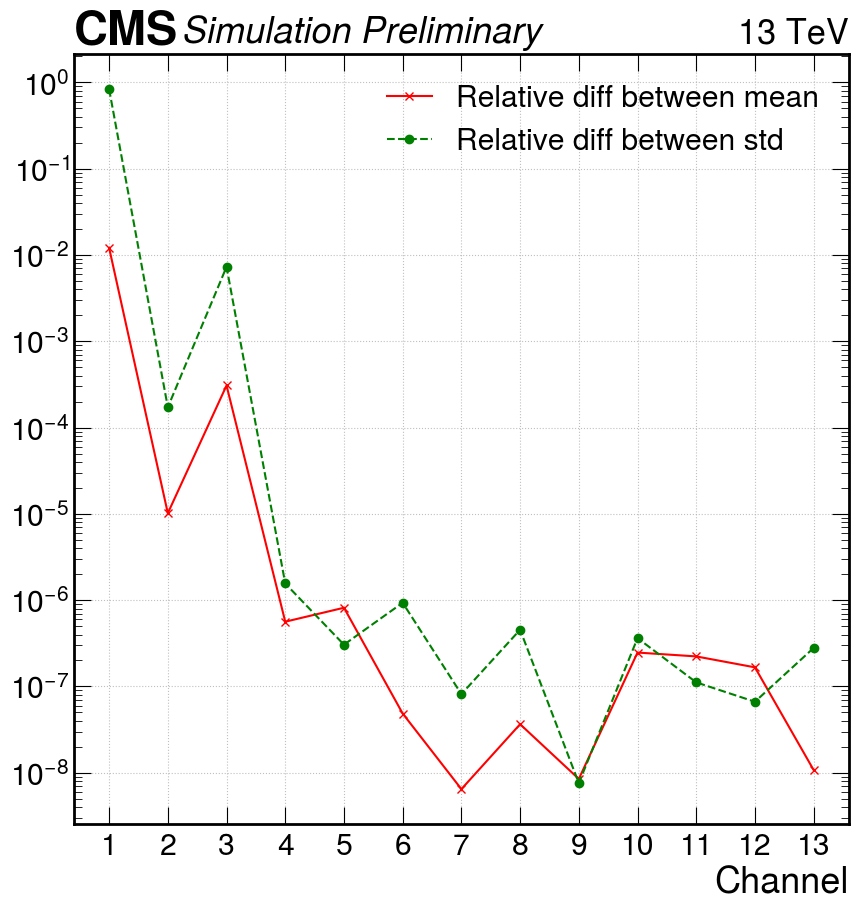

In [71]:
Channels = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

# Plotting
fig, ax = plt.subplots()
plt.plot(Channels, np.abs(orig_mean- after_outlier_mean)/orig_mean, marker='x',color = 'r',label='Relative diff between mean')
plt.plot(Channels, np.abs(orig_std- after_outlier_std)/orig_std, marker='o',linestyle='--',color = 'g',label='Relative diff between std')
# plt.plot(Channels, normalised_mean, marker='o', linestyle='--', color = 'b',label='normalised')
plt.xlabel('Channel')
plt.xticks(np.arange(1, 14, 1))
# plt.ylabel('Mean Value')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
plt.grid(True)
plt.minorticks_off()
plt.legend()
plt.yscale('log')
plt.show()
